<a href="https://colab.research.google.com/github/PrivetBoBo/FootballTransferMarket/blob/main/FootballTransferMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Football Transfer Market Data Analysis**

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline

#variables
colour=['maroon','r','g','darkgreen','c','teal','b','navy','indigo','m','deeppink','orange','sienna','yellow','khaki','olive','tan','black','grey','brown']

print("Packages installed")

Packages installed


**Get Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# import all files in Data folder and read into dataframes
dataframes=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/content/gdrive/data'):
    for filename in filenames:
        file=filename.split('.')
        file=((file[0]+"_df"))
        if file !="_df":
            filepath=os.path.join(dirname,filename)
            df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            dataframes.append(df)
print('Data imported')

appearances_df (1151986, 13)
clubs_df (411, 15)
competitions_df (43, 12)
player_valuations_df (419777, 7)
games_df (61043, 21)
game_events_df (554429, 7)
club_games_df (122086, 11)
players_df (28489, 23)
Data imported


In [ ]:
print(df)

       player_id                name  current_club_id   current_club_name country_of_citizenship    country_of_birth                     city_of_birth date_of_birth    position        sub_position   foot  height_in_cm  market_value_in_eur  highest_market_value_in_eur        agent_name contract_expiration_date current_club_domestic_competition_id     first_name    last_name         player_code                                          image_url  last_season                                                url
0         134354     Ian Raeymaekers              498         Ksc Lokeren                Belgium             Belgium                           Aalst       1/30/1995      Attack      Centre-Forward  Right             0                  NaN                      50000.0               NaN                      NaN                                  BE1            Ian  Raeymaekers     ian-raeymaekers  https://img.a.transfermarkt.technology/portrai...         2012  https://www.transfermarkt.co

**Process Data**

In [6]:
# Calculate the age of each player
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
# drop players with no date of birth
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 

# Calculate the contract remaining of each player
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
# drop players with no date of birth
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
now = datetime.now()
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 

# add year to player valuations
player_valuations_df['datetime']=pd.to_datetime(player_valuations_df['datetime'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['datetime'].dt.year

# add year to player appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

#add position to player valuations
position_df=players_df.copy()
position_df=position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
player_valuations_df=player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')

#add position to appearances
value_df=players_df.copy()
value_df=value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
appearances_df1=value_df.merge(appearances_df, left_on='player_id', right_on='player_id')

print("Data processing complete")

Data processing complete


 **Clubs Total Market Value**

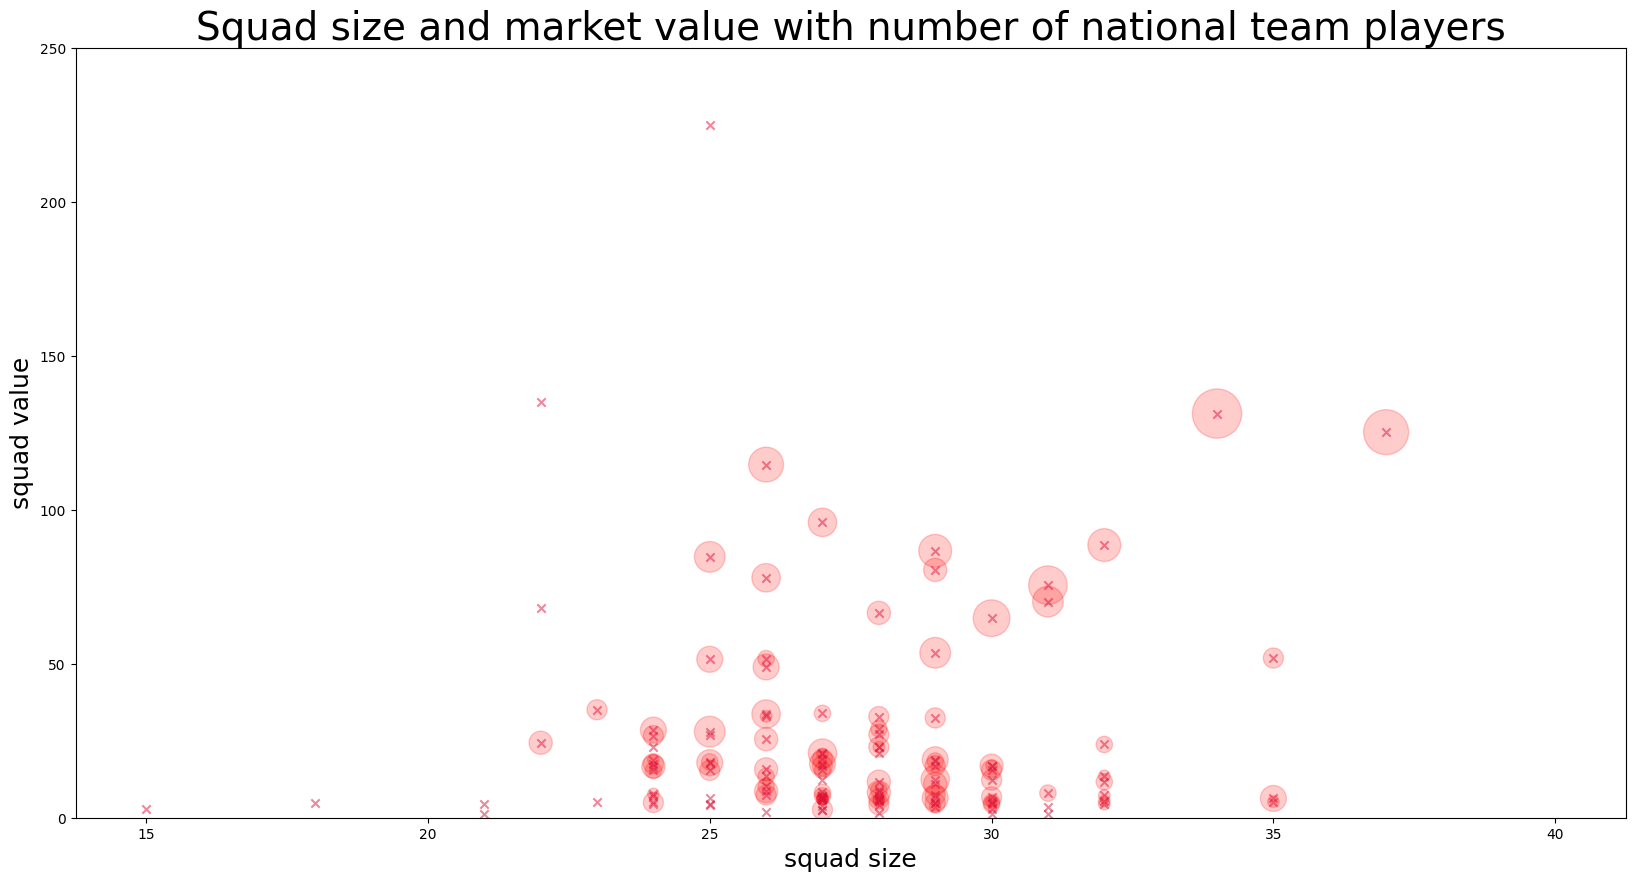

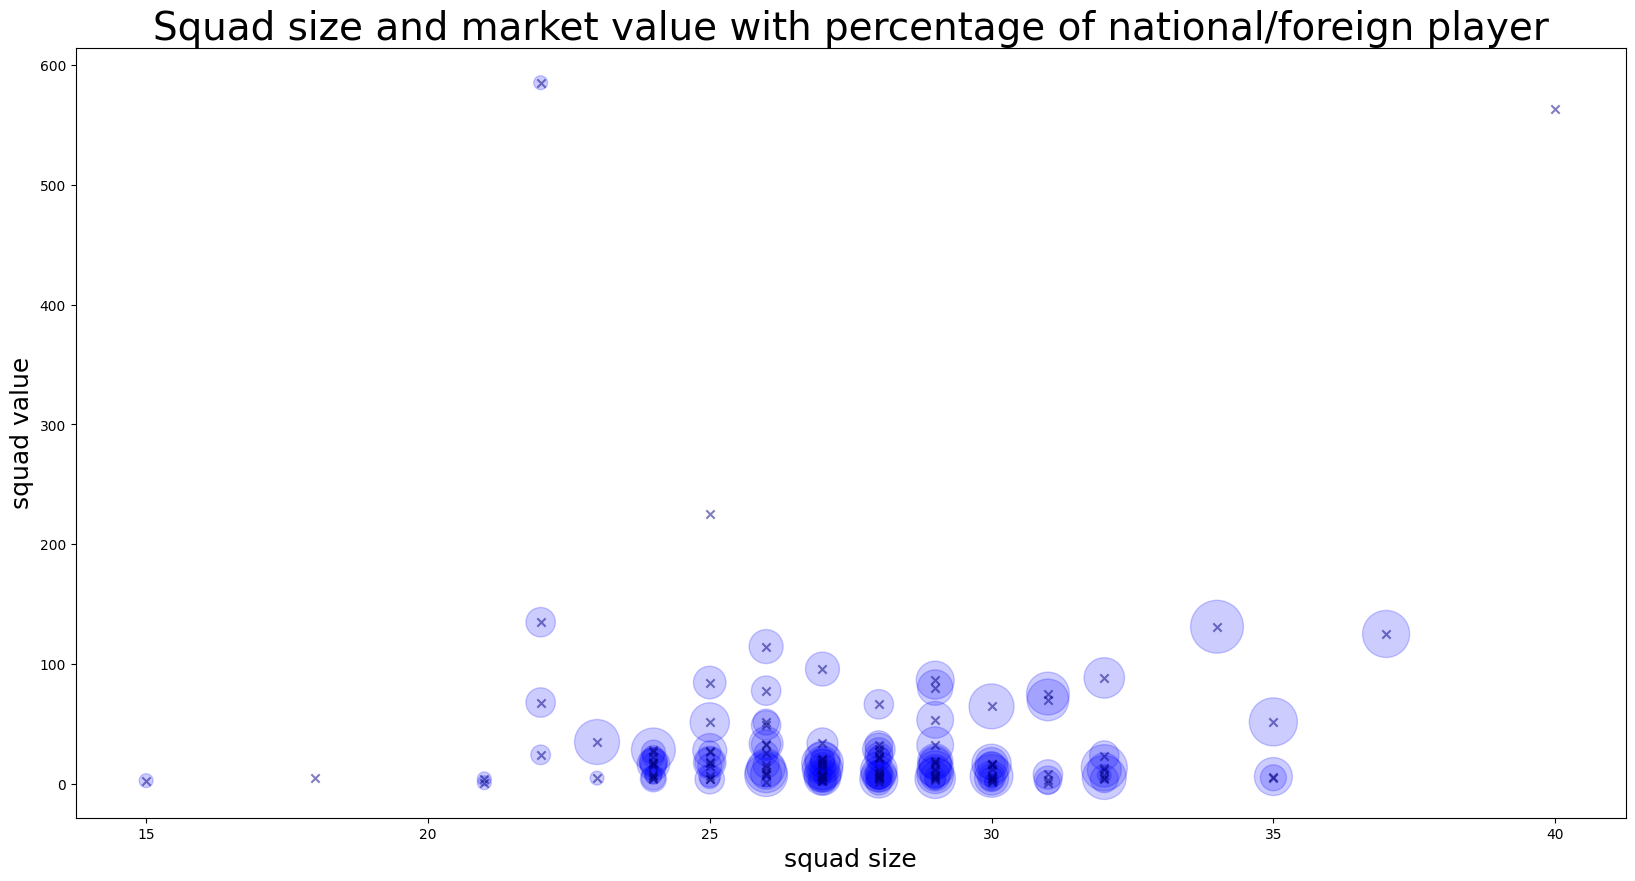

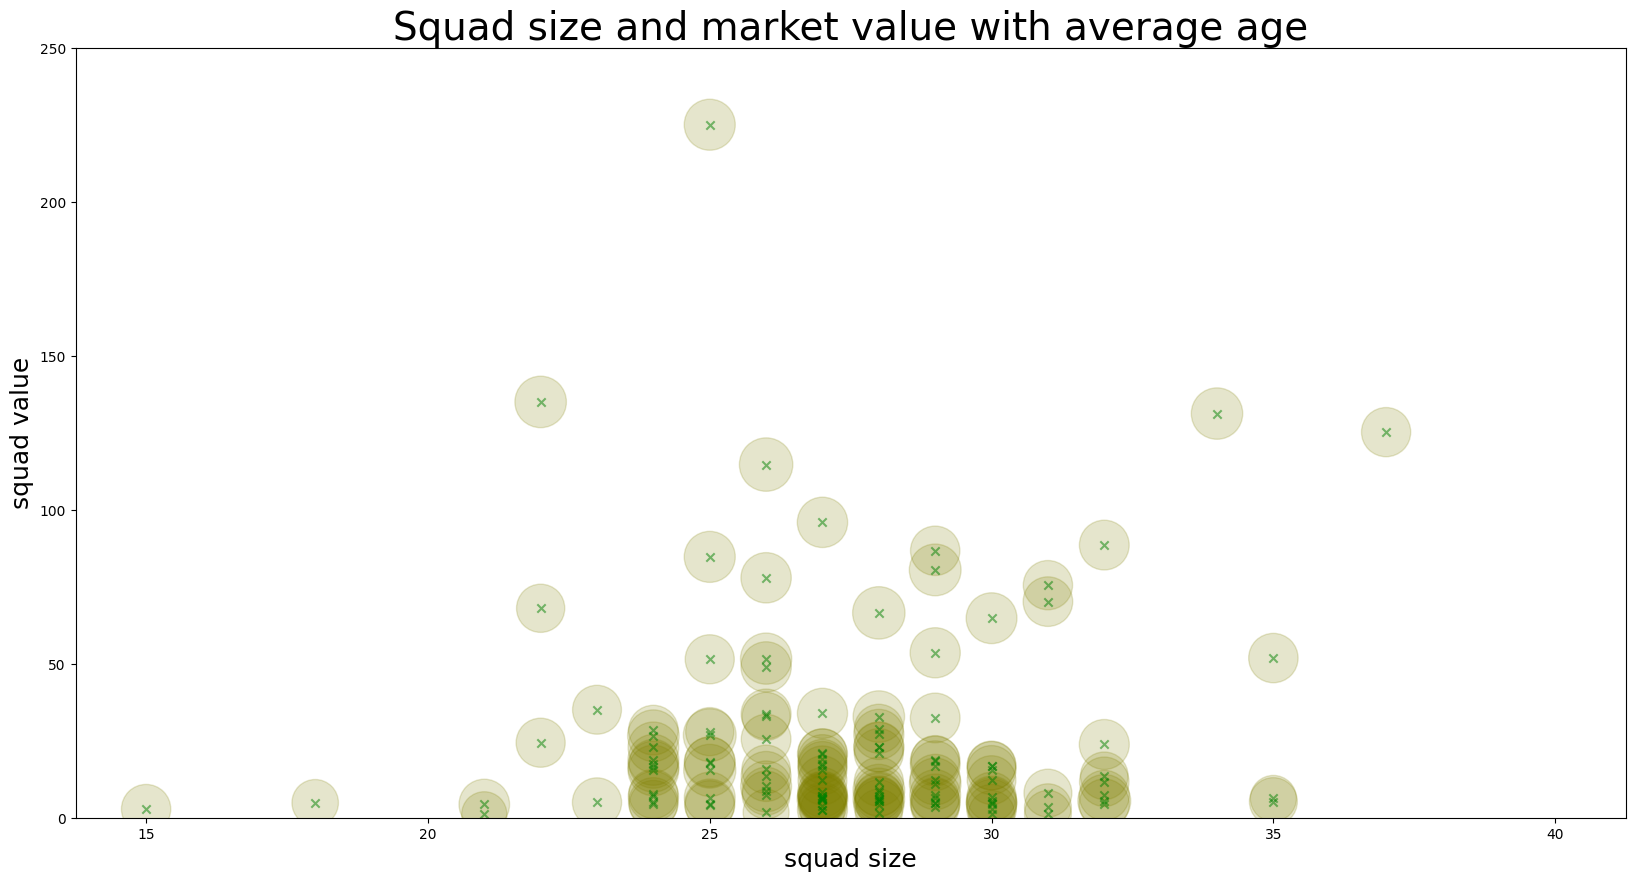

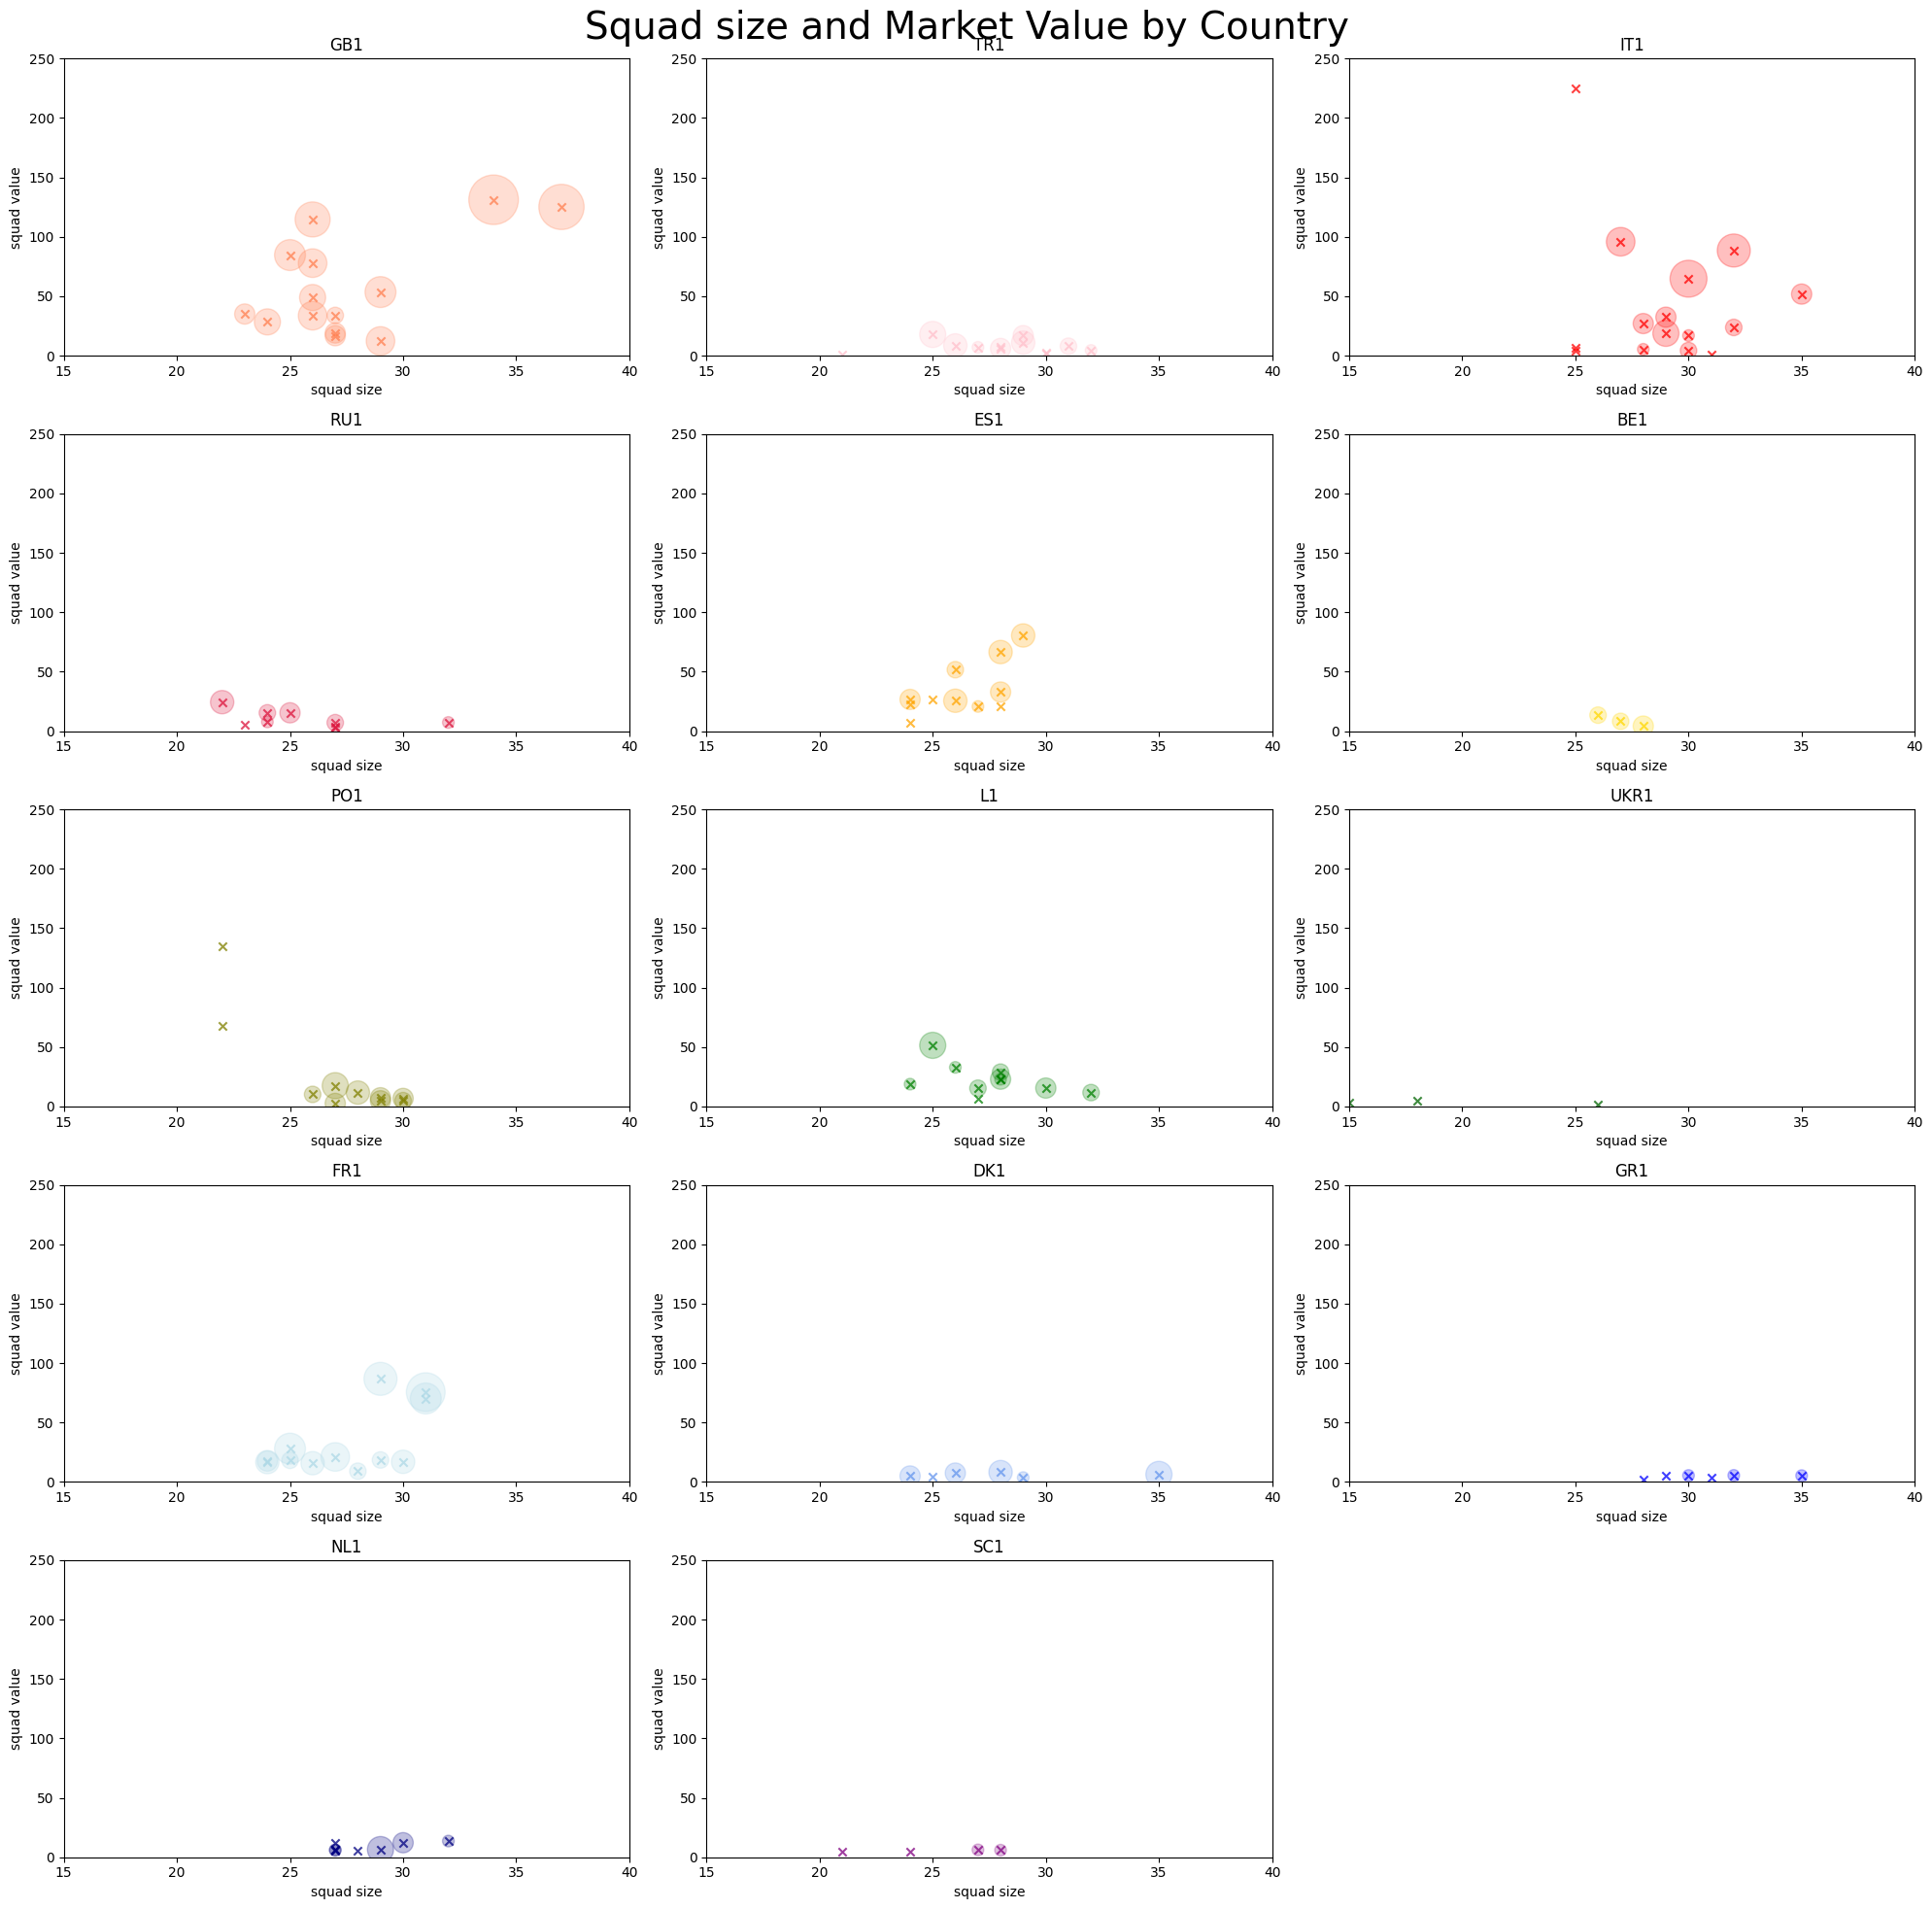

In [7]:
# look at dataframe
#print(clubs_df.columns); print(clubs_df.shape)

# Visualize of squad size, value and national team players
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='red',alpha=0.2, s=clubs_df['national_team_players']*70)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='crimson',alpha=0.5, marker='x')
plt.ylim(0,250)
plt.xlabel('squad size',fontsize=18); plt.ylabel('squad value',fontsize=18)
plt.title('Squad size and market value with number of national team players',fontsize=28)
plt.show()

# Visualize of squad size, value and national team players
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='blue',alpha=0.2, s=clubs_df['foreigners_number']*50)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='navy',alpha=0.5, marker='x')
plt.xlabel('squad size',fontsize=18); plt.ylabel('squad value',fontsize=18)
plt.title('Squad size and market value with percentage of national/foreign player',fontsize=28)
plt.show()

# Visualize of squad size, value and national team players
plt.figure(figsize=(20,10))
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='olive',alpha=0.2, s=clubs_df['average_age']*50)
plt.scatter(clubs_df['squad_size'],y=clubs_df['total_market_value'], c='green',alpha=0.5, marker='x')
plt.ylim(0,250) #;plt.xlim(15,40)
plt.xlabel('squad size',fontsize=18); plt.ylabel('squad value',fontsize=18)
plt.title('Squad size and market value with average age',fontsize=28)
plt.show()

# Visualize of squad size, value and national team players
n=1;colour=['coral','pink','r','crimson','orange','gold','olive','g','darkgreen','lightblue','cornflowerblue','b','navy','purple']
leagues=clubs_df.domestic_competition_id.unique()

plt.figure(figsize=(20,20))
plt.suptitle("Squad size and Market Value by Country", size=28)
for league in leagues:
    plt.subplot(5,3,n);n=n+1
    clubs_df1 = clubs_df[(clubs_df.domestic_competition_id==league)] 
    plt.scatter(clubs_df1['squad_size'],y=clubs_df1['total_market_value'], label=league,color=colour[n-2],alpha=0.25, s=clubs_df1['national_team_players']*75)
    plt.scatter(clubs_df1['squad_size'],y=clubs_df1['total_market_value'], color=colour[n-2],alpha=0.75, marker='x')
    plt.xlabel('squad size'); plt.ylabel('squad value')
    plt.ylim(0,250);plt.xlim(15,40)
    plt.title(league);#plt.legend()
    plt.tight_layout()
plt.show()

**Player Valuation Data Visualization**

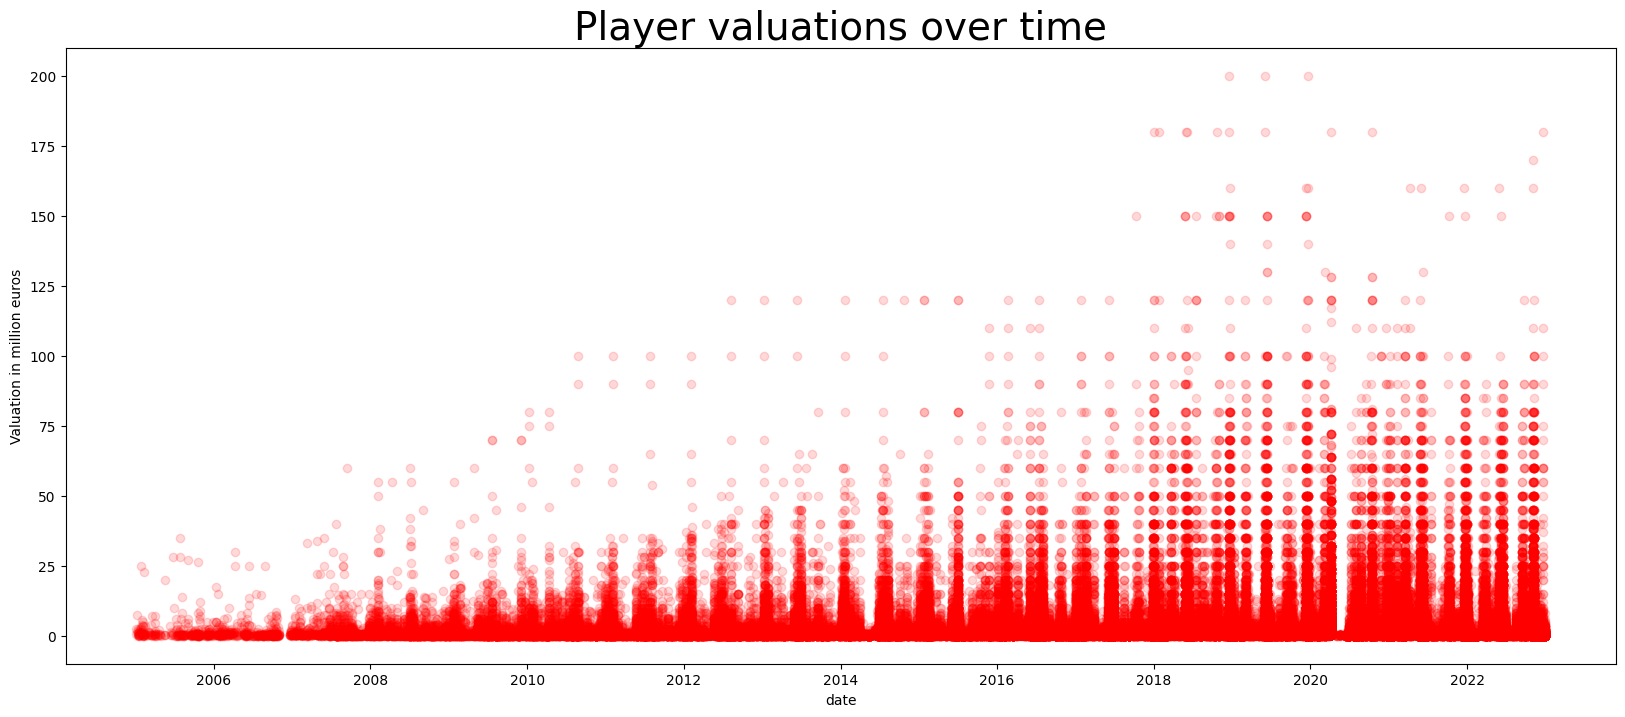

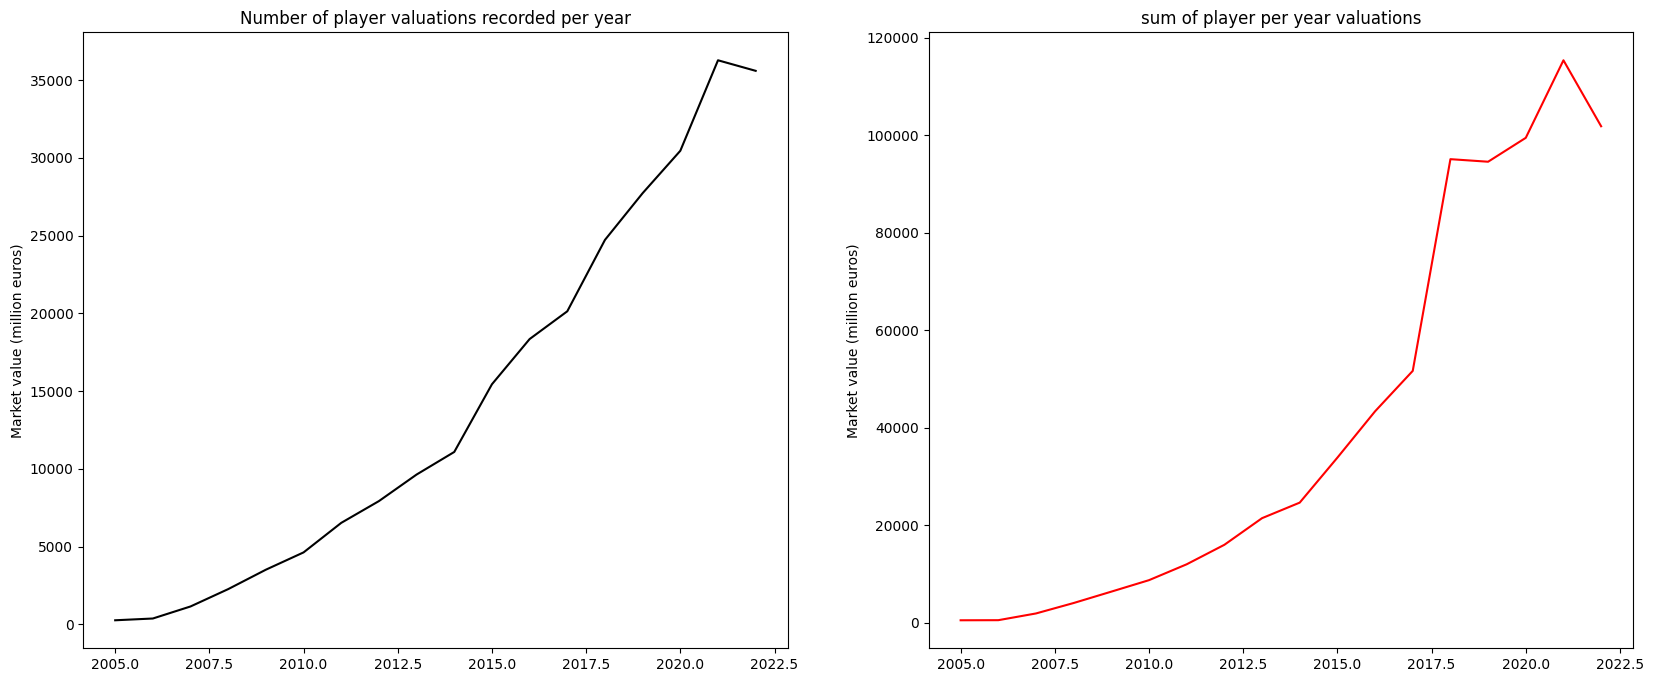

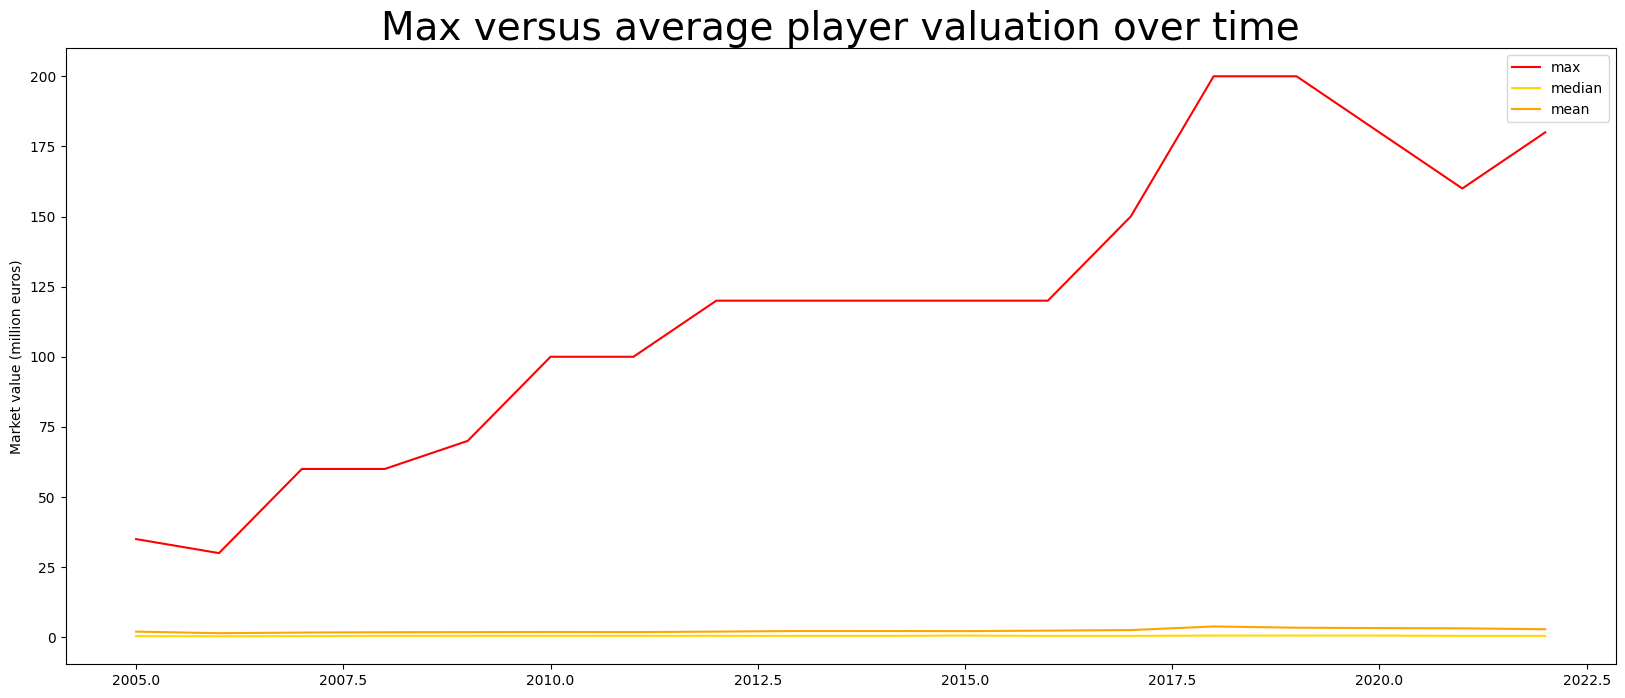

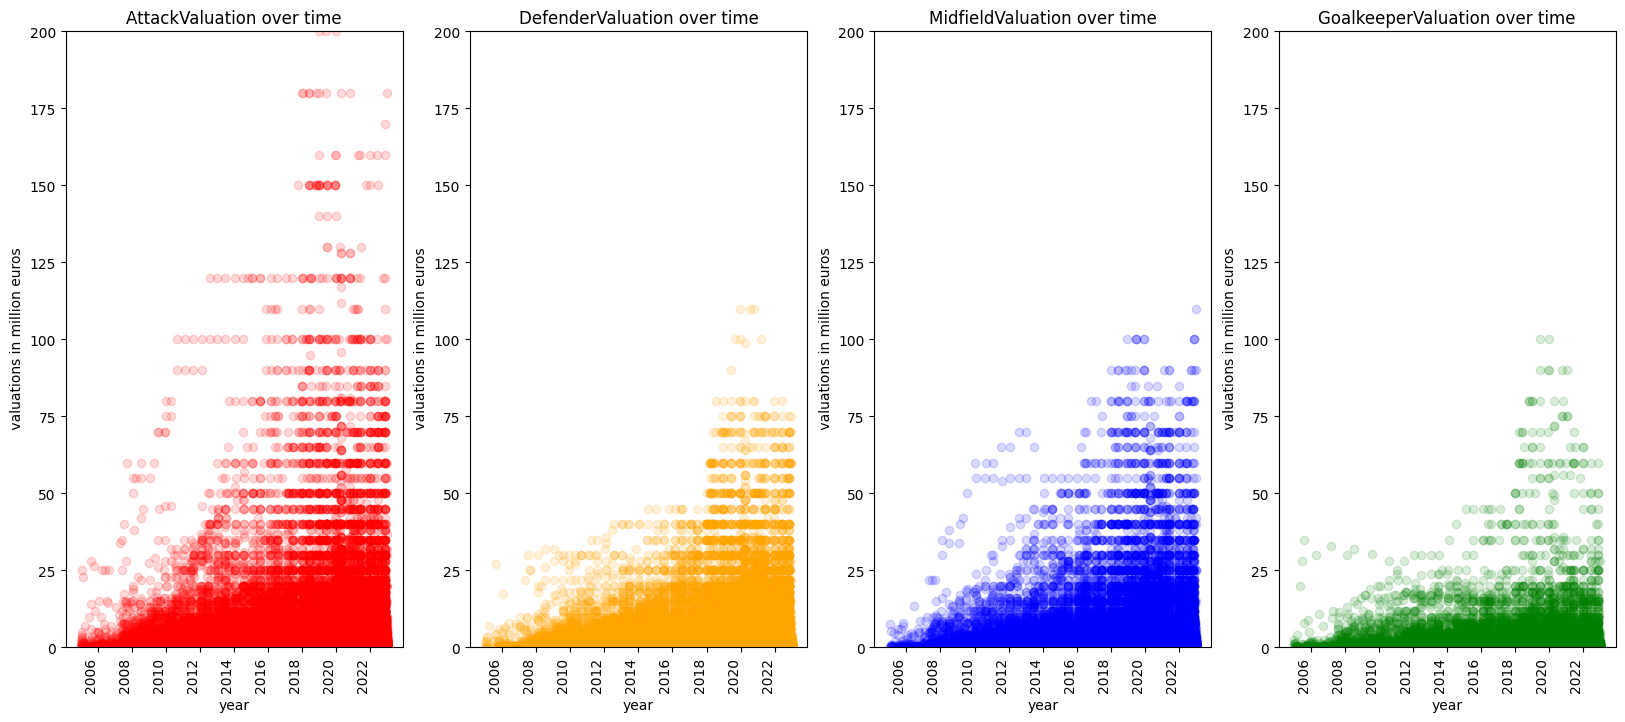

In [8]:
#filter range
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004 ) & (player_valuations_df.year < 2023 )]
high_value_player_valuations_df = player_valuations_df[(player_valuations_df.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Lookat data
#print(player_valuations_df.columns)

# Visualize of valuation data over time
plt.figure(figsize=(20,8))
plt.scatter(player_valuations_df['datetime'],y=player_valuations_df['market_value_in_eur']/1000000, c='red',alpha=0.15)
plt.xlabel('date');plt.ylabel('Valuation in million euros')
plt.title('Player valuations over time',fontsize=28)
plt.show()

# Visualize of valuation data over time
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
yeargroups1 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).count() \
    .sort_values(by='year', ascending=True)
yeargroups2 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).sum() \
    .sort_values(by='year', ascending=True)
yeargroups3 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).max() \
    .sort_values(by='year', ascending=True)
yeargroups4 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).min() \
    .sort_values(by='year', ascending=True)
yeargroups5 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).median() \
    .sort_values(by='year', ascending=True)
yeargroups6 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).mean() \
    .sort_values(by='year', ascending=True)

plt.subplot(1, 2, 1)                 
plt.title('Number of player valuations recorded per year')
plt.plot(yeargroups1.index,yeargroups1,color='black')
plt.ylabel('Market value (million euros)')
plt.subplot(1, 2, 2)
plt.title('sum of player per year valuations')
plt.plot(yeargroups2.index,yeargroups2/1000000,color='red')
plt.ylabel('Market value (million euros)')
plt.show()
plt.figure(figsize=(20,8))
plt.title('Max versus average player valuation over time',fontsize=28)
plt.plot(yeargroups3.index,yeargroups3/1000000,color='r',label='max')
plt.plot(yeargroups5.index,yeargroups5/1000000,color='Gold',label='median')
plt.plot(yeargroups6.index,yeargroups6/1000000,color='Orange',label='mean')
plt.ylabel('Market value (million euros)')
plt.legend()
plt.show()

# valuation by position
plt.figure(figsize=(20,8))
n=1;colour=['yellow','r','orange','b','g']
for position in positions:
    plt.subplot(1,4,n);n=n+1
    player_valuations_df1 = player_valuations_df[(player_valuations_df.position==position)]                                             
    plt.scatter(player_valuations_df1['datetime'],y=player_valuations_df1['market_value_in_eur']/1000000, c=colour[n-1],alpha=0.15)
    plt.xlabel('year')
    plt.ylabel(' valuations in million euros')
    plt.title(position+'Valuation over time')
    plt.ylim(0,200)
    plt.xticks(rotation=90, ha='right')
plt.show()  

**Player Data Visualization**

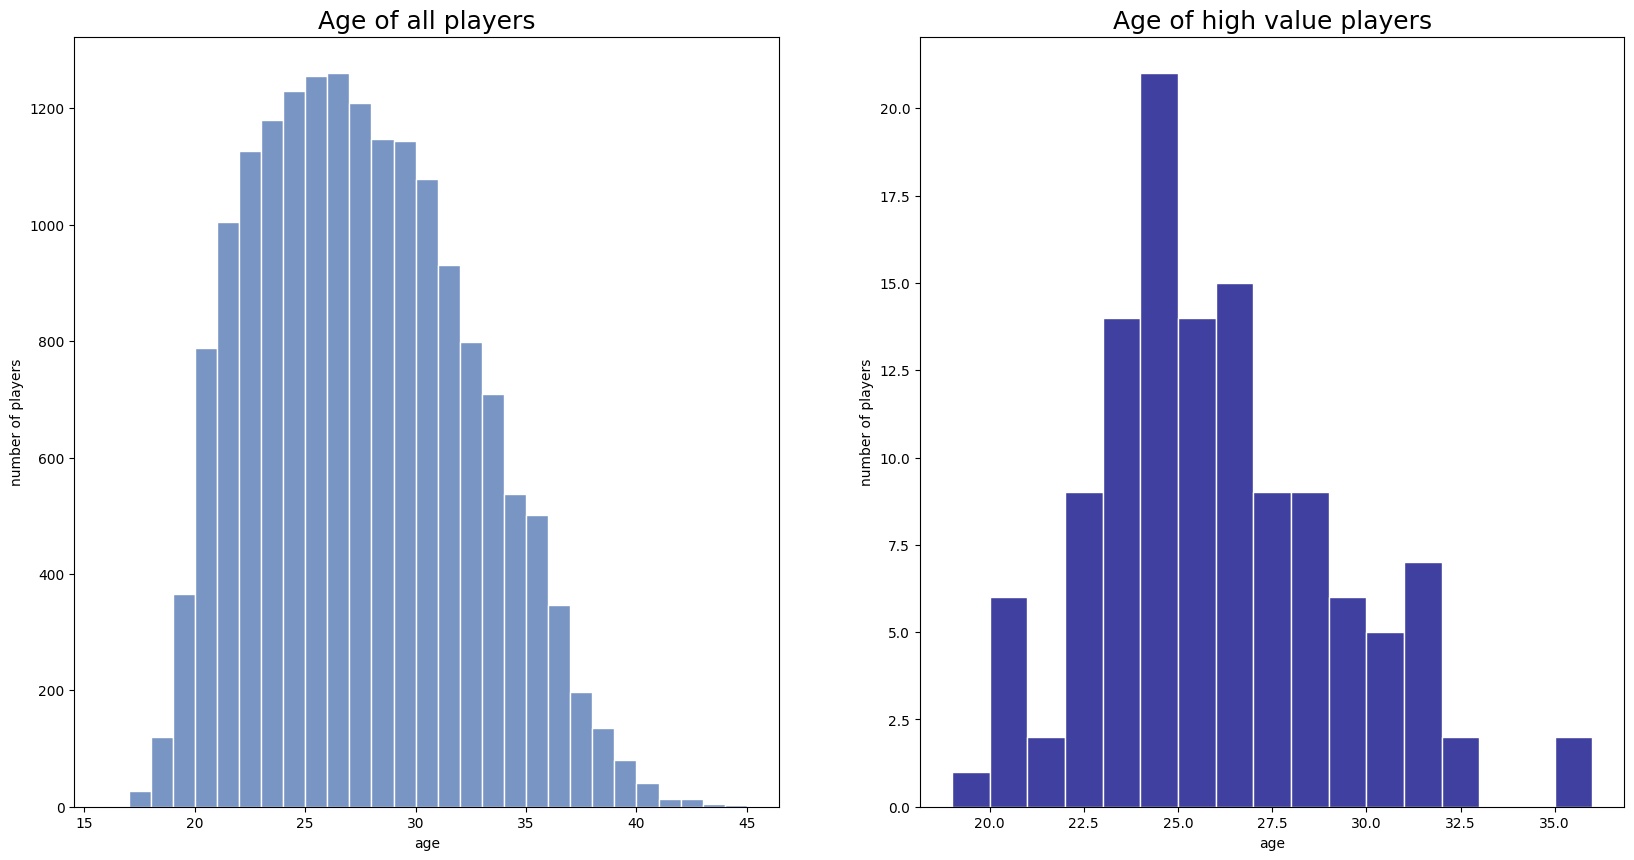

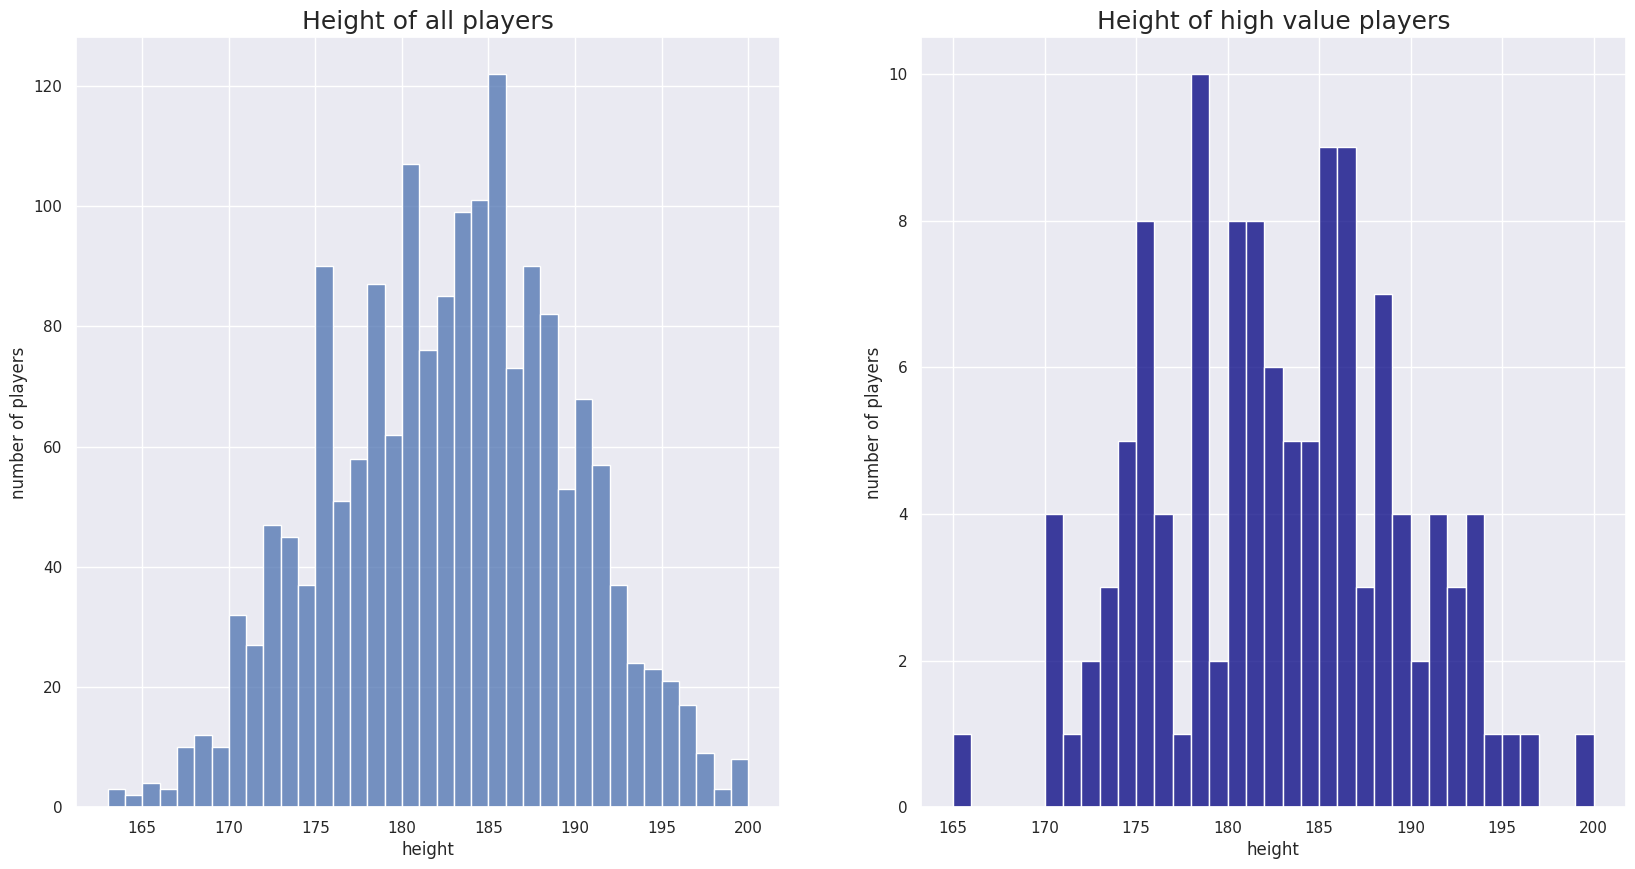

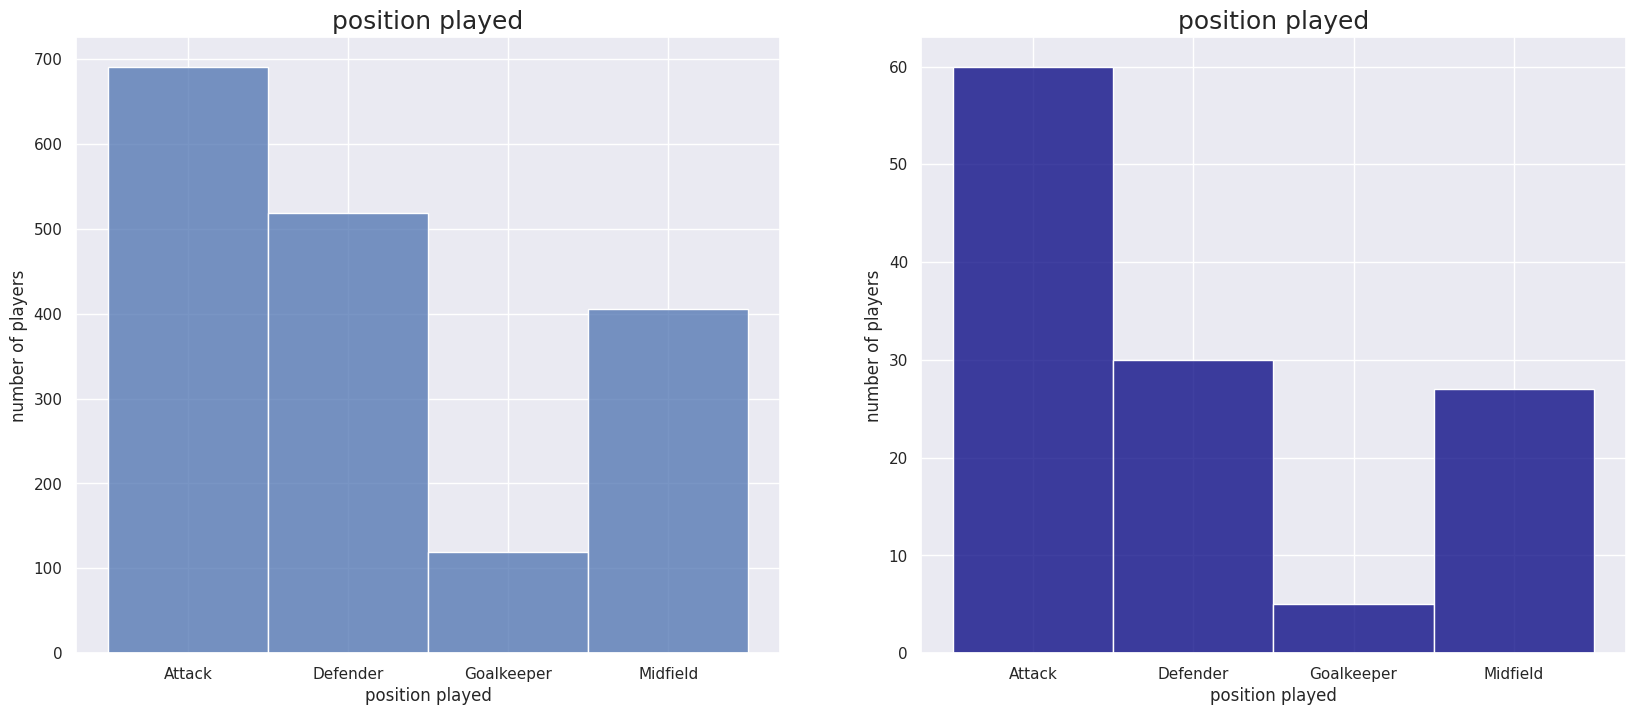

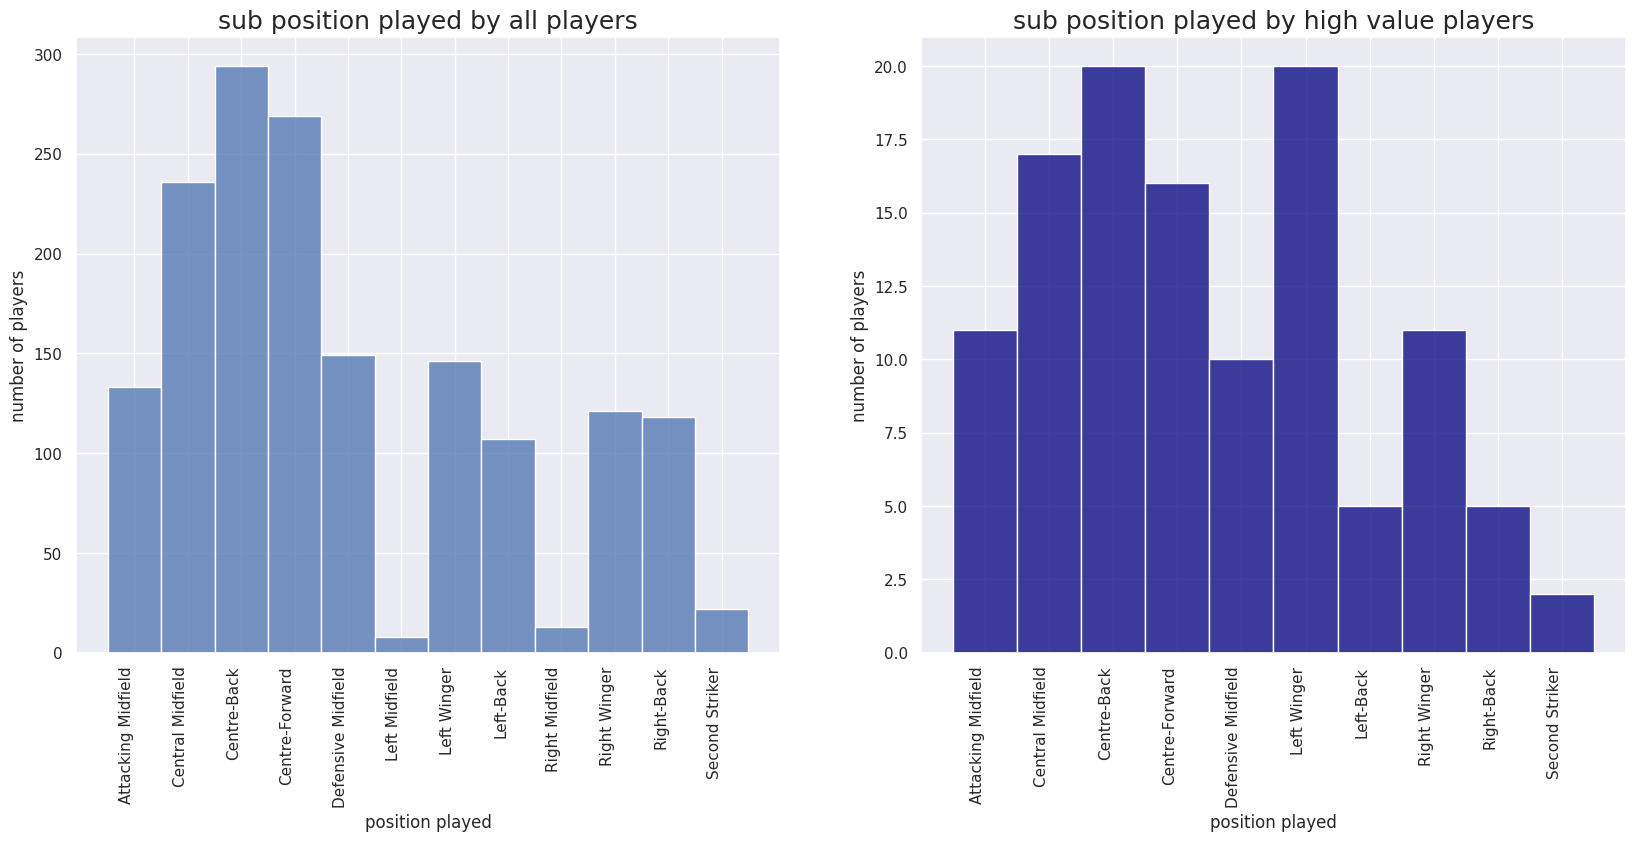

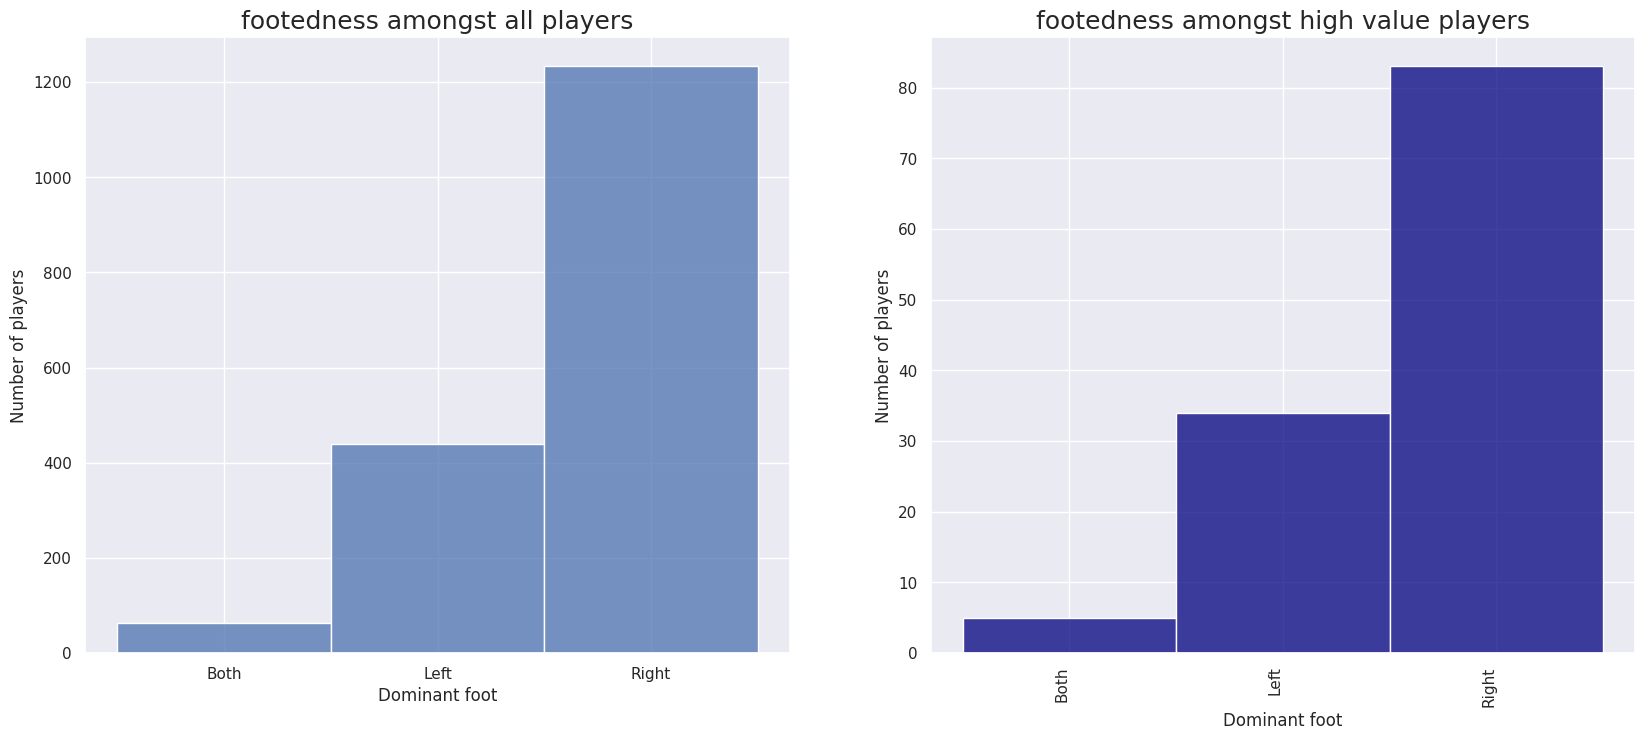

In [9]:
#overview of player dataset
#remove players with no Market Value
players_df1 = players_df[players_df.highest_market_value_in_eur.isnull() == False]
#order by Market Value
players_df1 = players_df1.sort_values("highest_market_value_in_eur", ascending = False)
#filter by season and value
players_df1 = players_df[players_df['last_season'] >= 2021]
players_df1 = players_df1[players_df1['highest_market_value_in_eur'] >= 10000000]
high_value_players_df = players_df1[(players_df1.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Show player age distribution
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='age',data=players_df, binwidth=1,color='b')
plt.title("Age of all players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='age',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Age of high value players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')

# Show player height distribution
players_df3 = players_df1[players_df1.height_in_cm.isnull() == False]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='height_in_cm',data=players_df3, binwidth=1,color='b')
plt.title("Height of all players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='height_in_cm',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Height of high value players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')

# Show position data
players_df1 = players_df1.sort_values("position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
plt.title("position played",fontsize=18);plt.grid(True)
sns.histplot(x='position',data=players_df1, binwidth=1,color='b')
plt.xlabel('position played'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("position played",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')

# Show subposition data
players_df1 = players_df1.sort_values("sub_position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("sub_position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='sub_position',data=players_df1, binwidth=1,color='b')
plt.title("sub position played by all players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');
plt.subplot(1, 2, 2)
sns.histplot(x='sub_position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("sub position played by high value players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');

# Show  footedness data
players_df1 = players_df1.sort_values("foot", ascending = True)
high_value_players_df1 = high_value_players_df1.sort_values("foot", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='foot',data=players_df1, binwidth=1,color='b')
plt.title("footedness amongst all players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='foot',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("footedness amongst high value players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.xticks(rotation=90, ha='right');

**Appearance Visualizations**

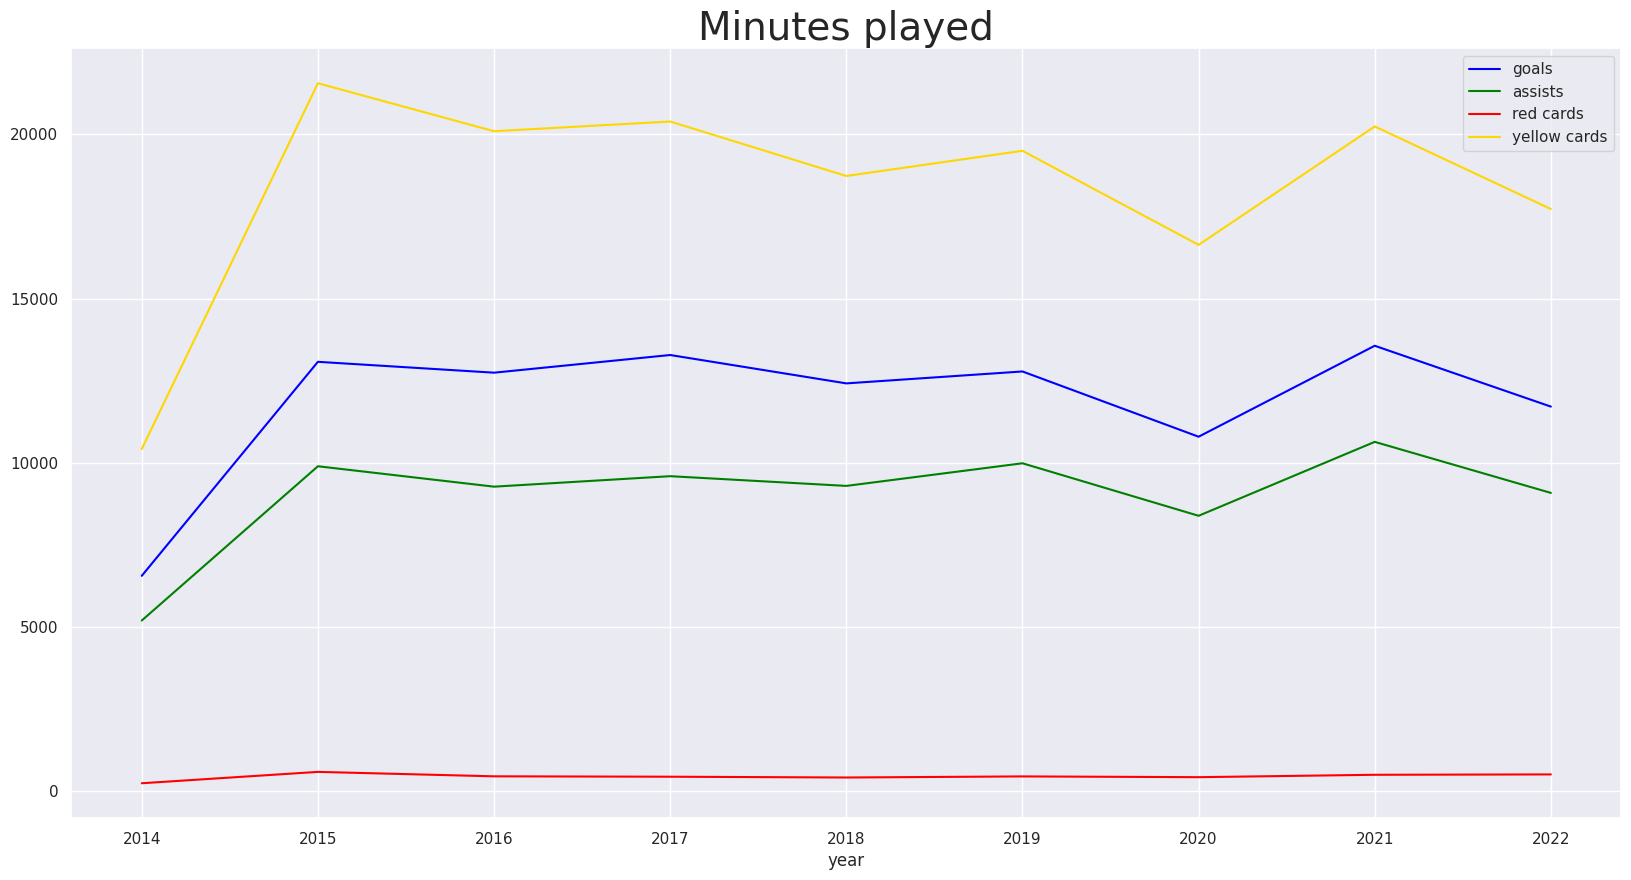

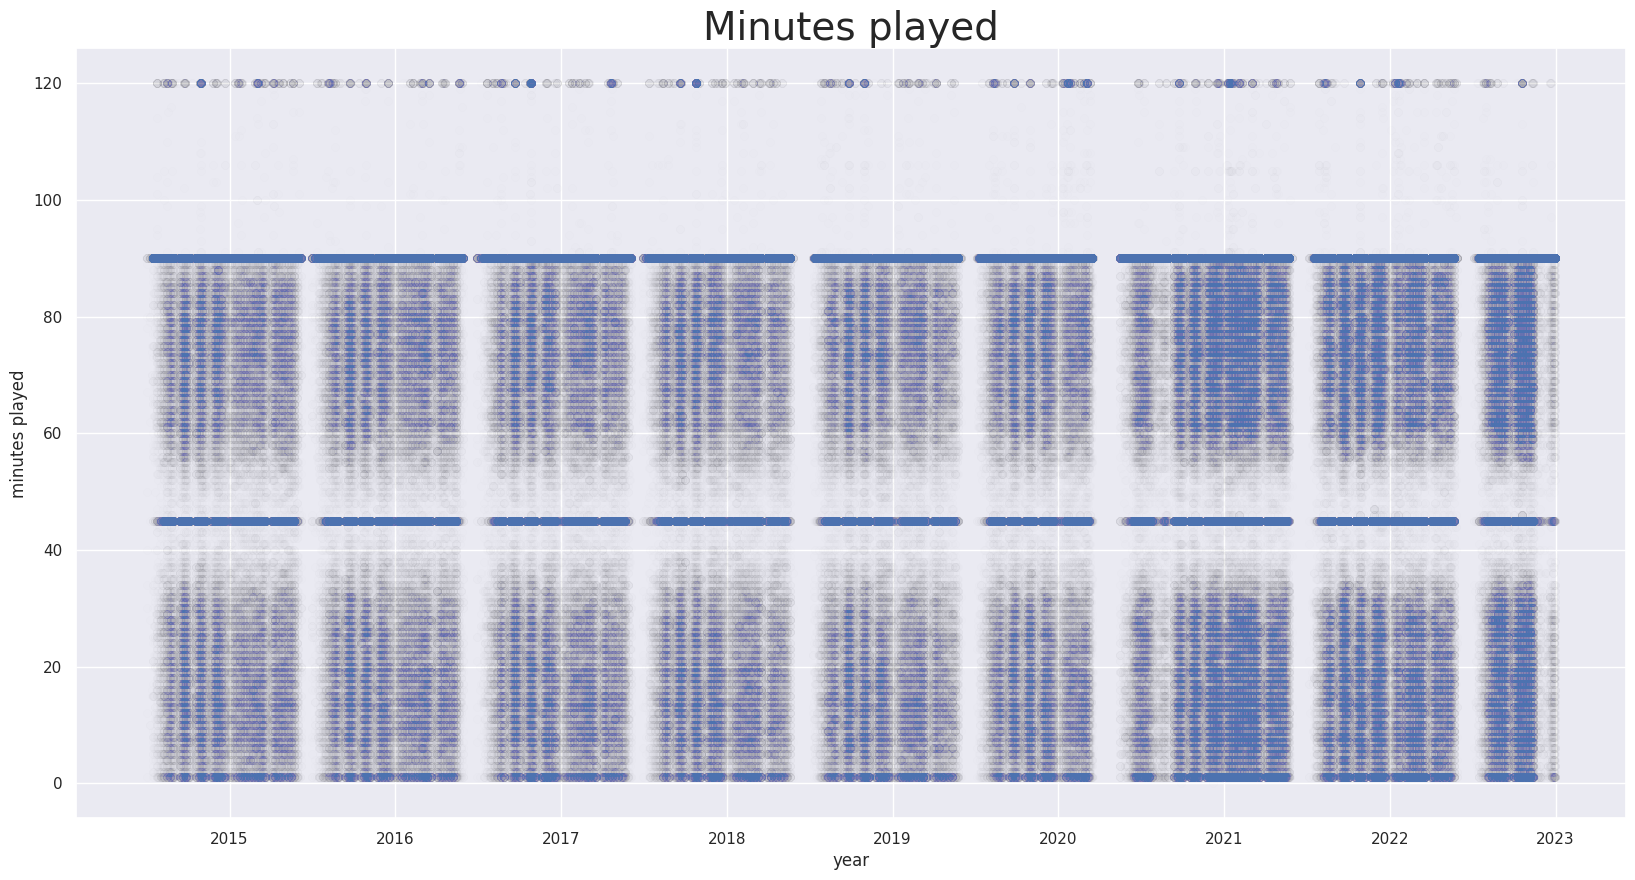

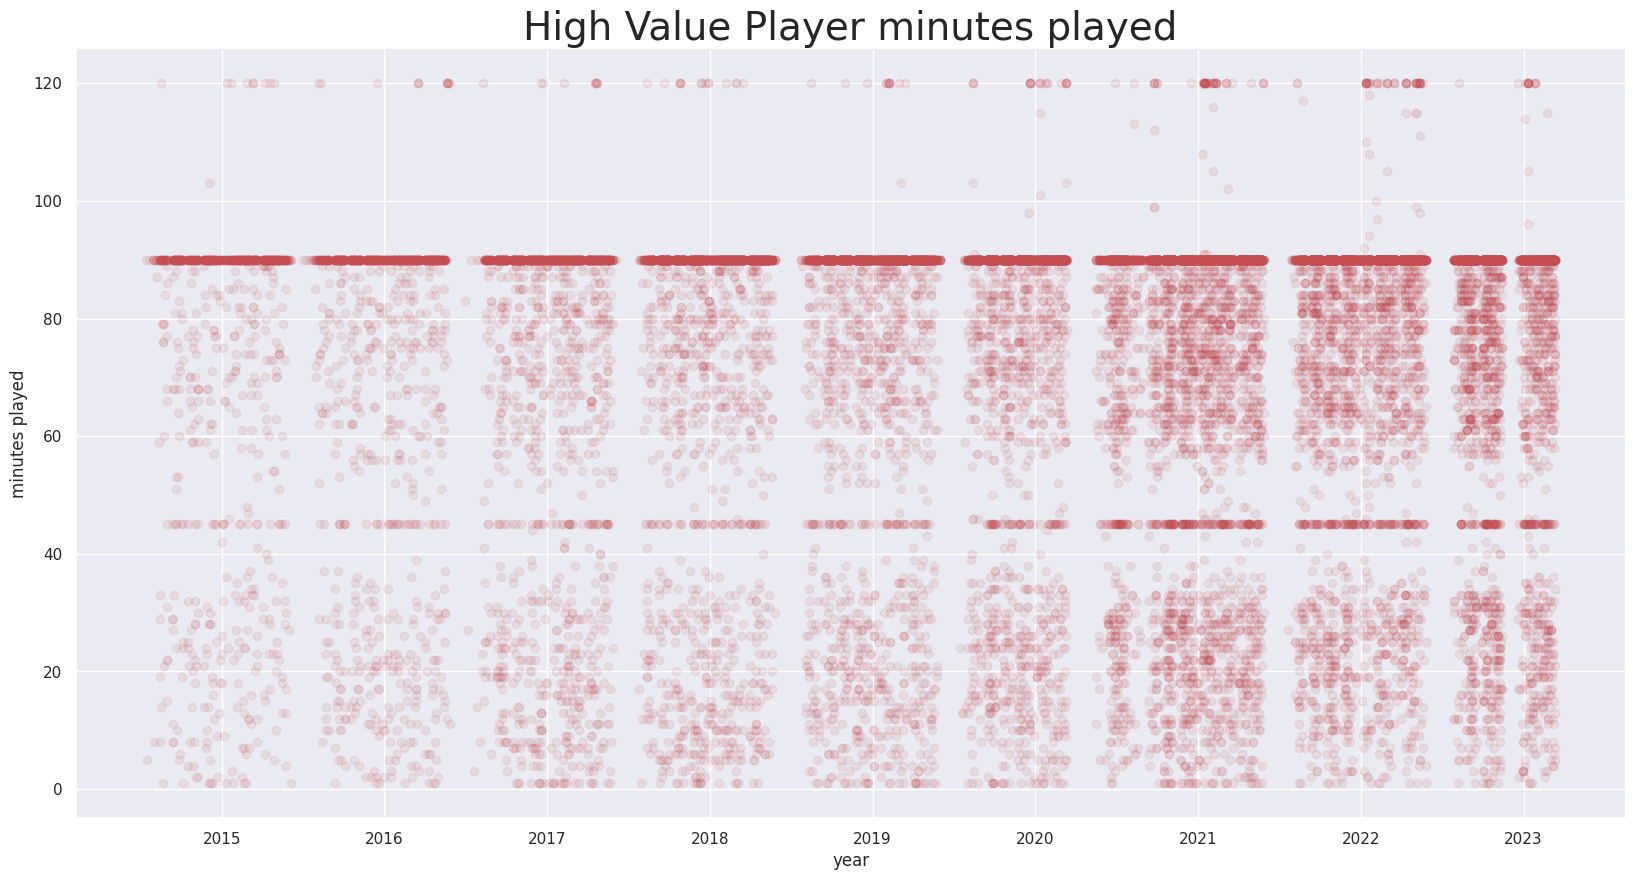

In [10]:
#print(appearances_df.columns); print(appearances_df.shape)

#filter range
appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
high_value_appearances_df = appearances_df1[(appearances_df1.market_value_in_eur > 40000000 )]

#Goals, assists and cards
yeargroups1 = appearances_df.loc[:,['goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = appearances_df.loc[:,['assists', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups3 = appearances_df.loc[:,['red_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups4 = appearances_df.loc[:,['yellow_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='goals')
plt.plot(yeargroups2.index,yeargroups2,color='green',label='assists')
plt.plot(yeargroups3.index,yeargroups3,color='red',label='red cards')
plt.plot(yeargroups4.index,yeargroups4,color='gold',label='yellow cards')
plt.xlabel("year")
plt.title('Minutes played',fontsize=28);plt.legend()
plt.show()

# Explore minutes played
plt.scatter(appearances_df['datetime'],y=appearances_df['minutes_played'],alpha=0.0025,color='b')
plt.xlabel("year");plt.ylabel('minutes played')
plt.title('Minutes played',fontsize=28)
plt.show()

# Explore minutes played
plt.scatter(high_value_appearances_df['datetime'],y=high_value_appearances_df['minutes_played'],alpha=0.1,color='r')
plt.xlabel("year");plt.ylabel('minutes played')
plt.title('High Value Player minutes played',fontsize=28)
plt.show()

**Game Visualizations**

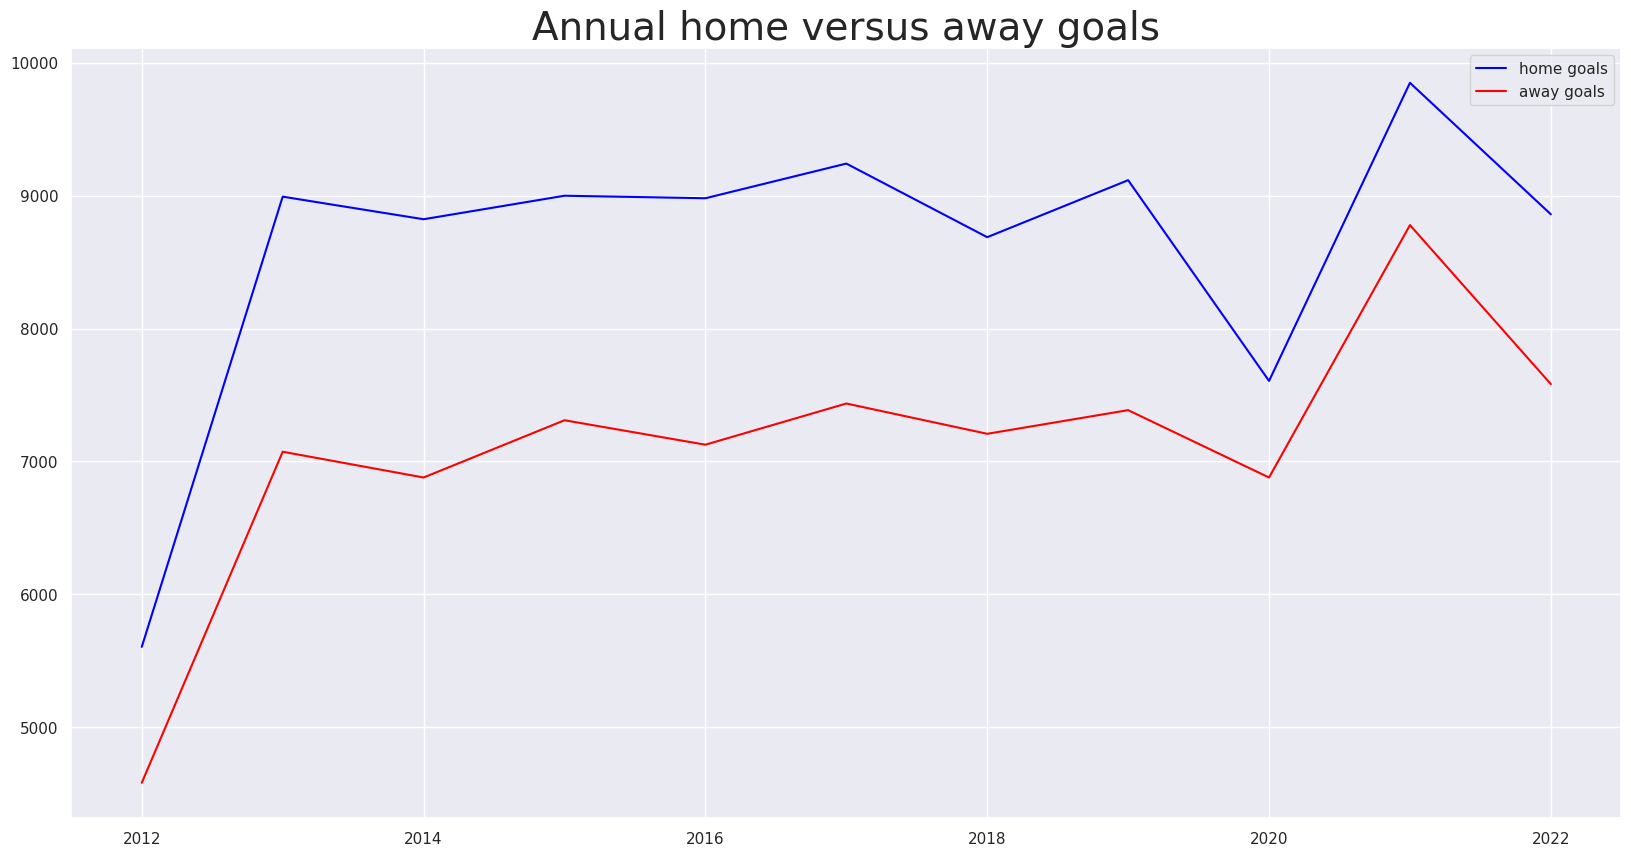

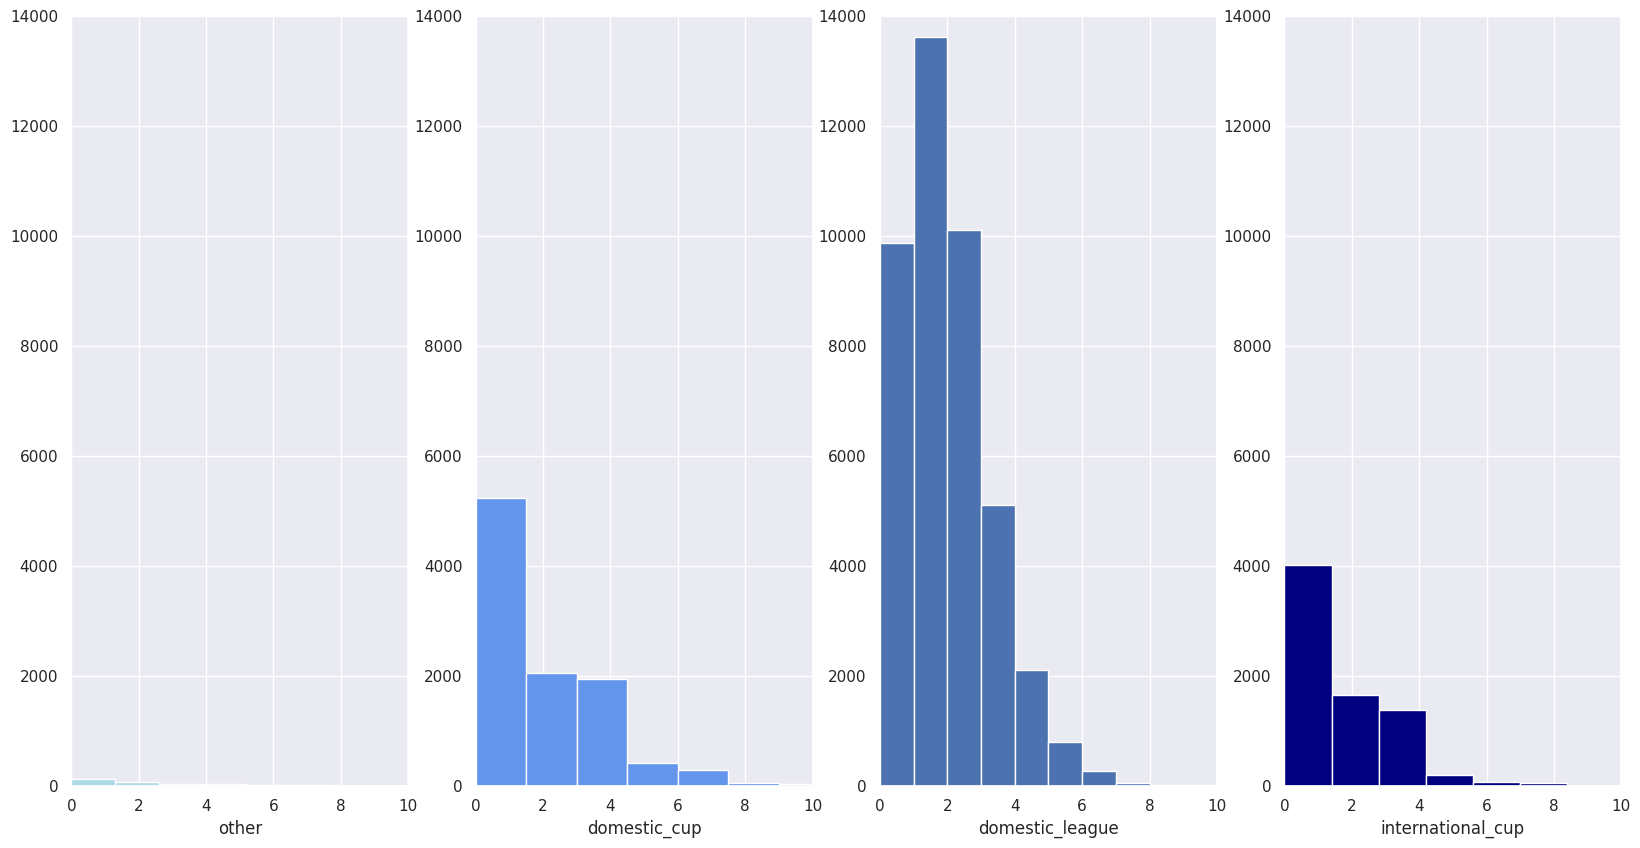

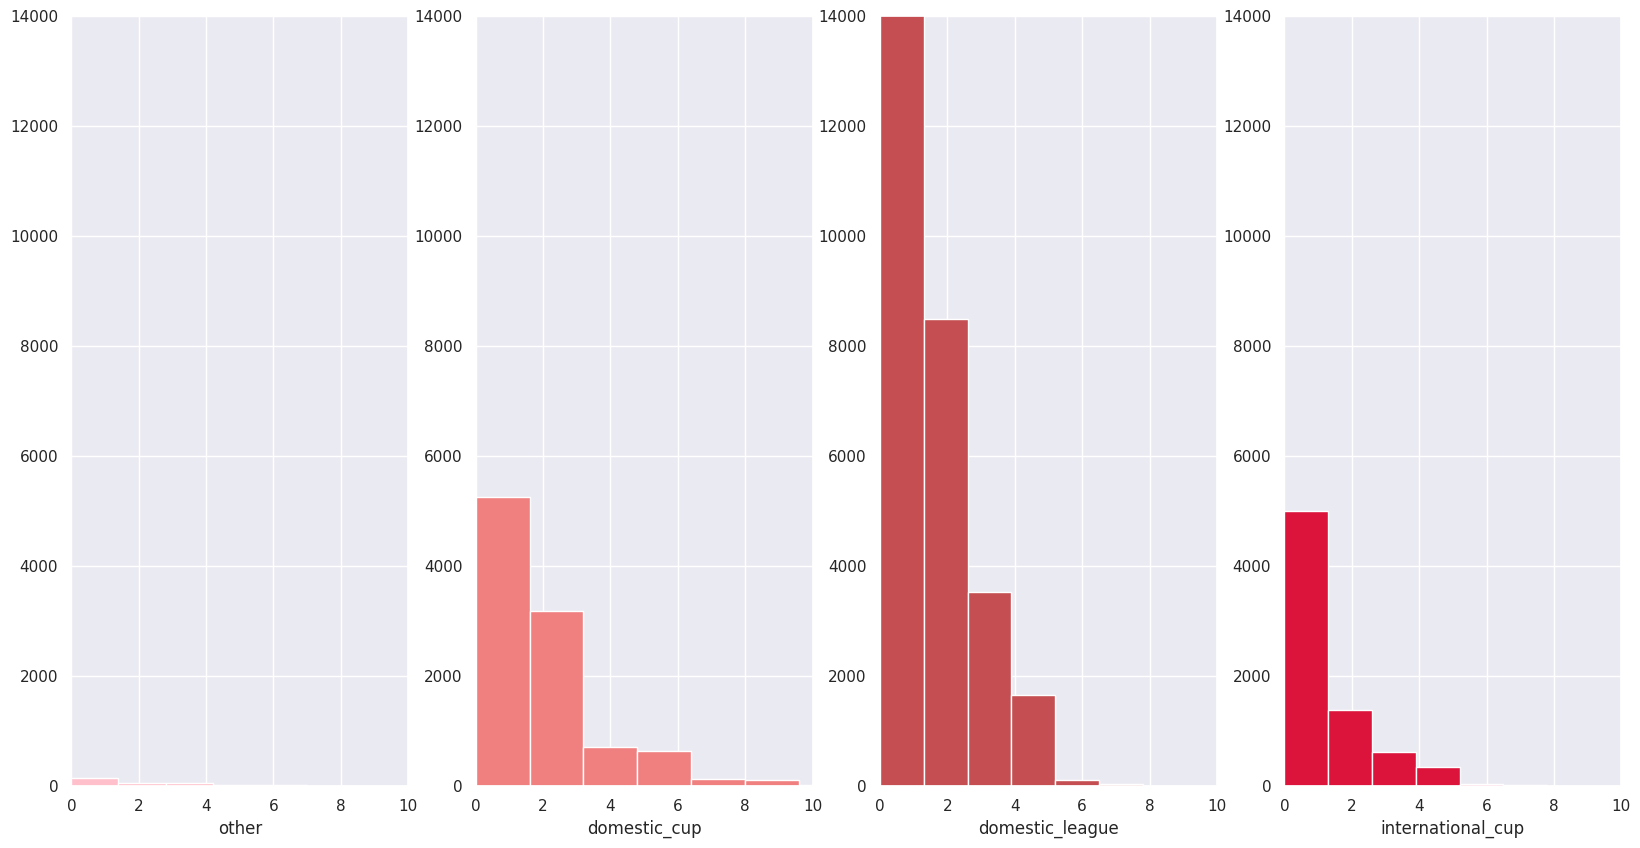

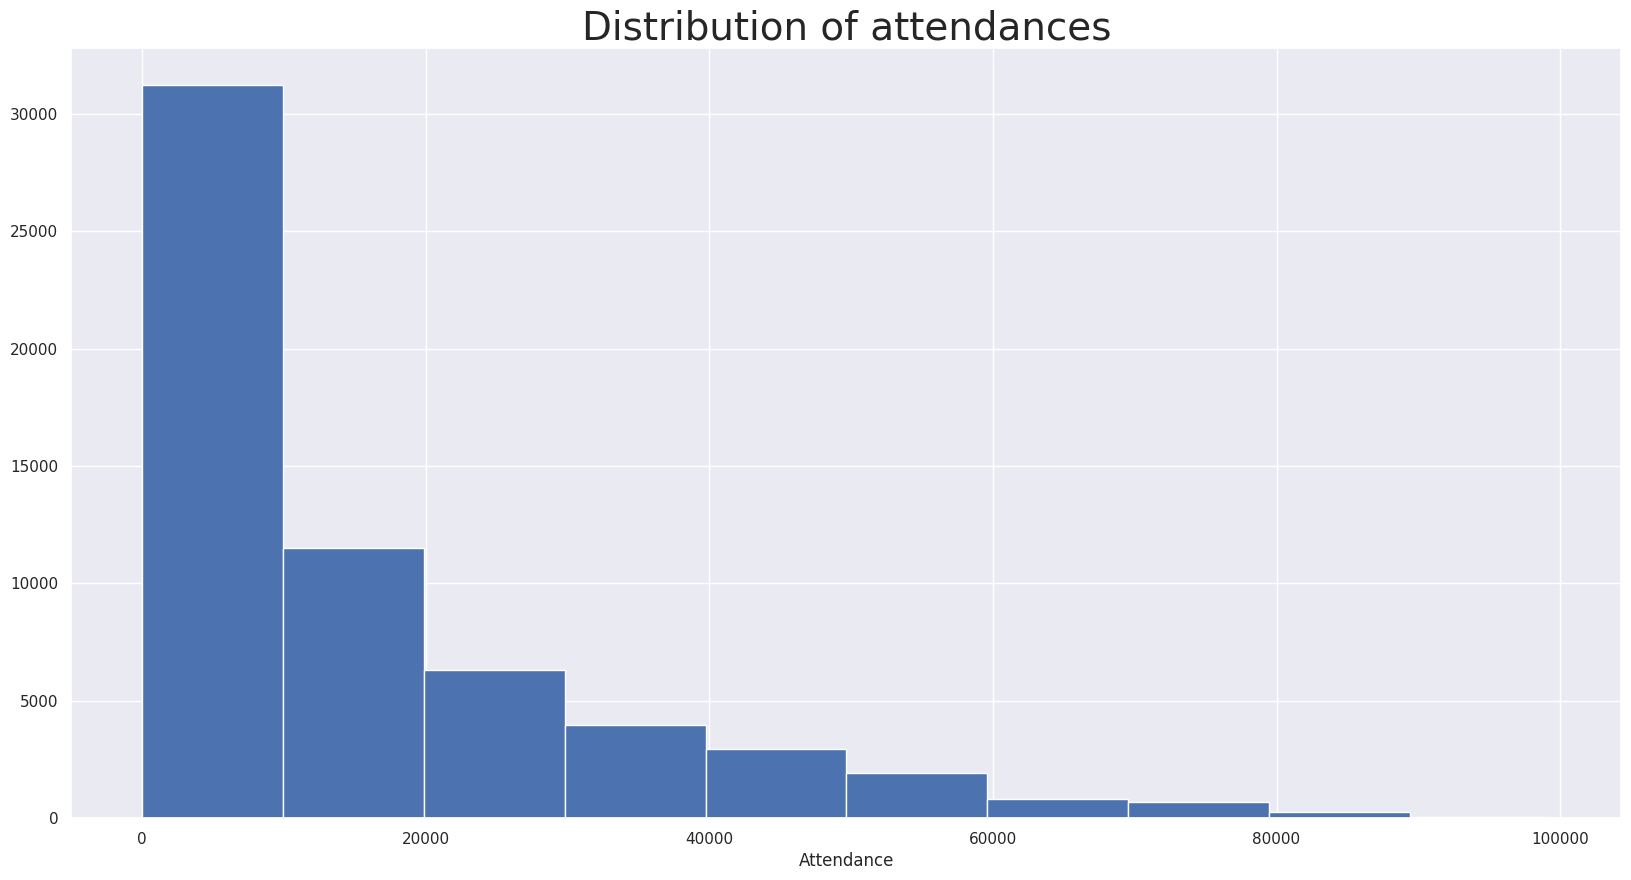

In [11]:
#print(games_df.columns) ; print(games_df.shape)

#add year to game valuations
games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
games_df['year']=games_df['datetime'].dt.year

#filter range
games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]

# annual home versus away goals
plt.title('Annual home versus away goals',fontsize=28)
yeargroups1 = games_df.loc[:,['home_club_goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = games_df.loc[:,['away_club_goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='home goals')
plt.plot(yeargroups2.index,yeargroups2,color='red',label='away goals')
plt.legend()
plt.show()

#home goals by competition type
n=1;colour=['b','lightblue','cornflowerblue','b','navy']
competition_type=games_df.competition_type.unique()
for type in competition_type:
    plt.subplot(1,4,n);n=n+1
    games_df1 = games_df[(games_df.competition_type==type)] 
    plt.hist(games_df1['home_club_goals'],color=colour[n-1])
    plt.ylim(0,14000);plt.xlim(0,10)
    plt.xlabel(type)
plt.show()

#away goals by competition type
n=1;colour=['yellow','pink','lightcoral','r','crimson','brick']
for type in competition_type:
    plt.subplot(1,4,n);n=n+1
    games_df1 = games_df[(games_df.competition_type==type)] 
    plt.hist(games_df1['away_club_goals'],color=colour[n-1])
    plt.ylim(0,14000);plt.xlim(0,10)
    plt.xlabel(type)
plt.show()

# distribution of attendances
plt.hist(games_df['attendance'])
plt.title('Distribution of attendances',fontsize=28)
plt.xlabel('Attendance')
plt.show()

# attendance by year
#n=1;colour=['yellow','r','orange','b','g'];years=games_df['year'].unique()
#for year in years:
#    plt.subplot(1,len(years),n);n=n+1
#    attendance_df1 = games_df[(games_df.year==year)]                                             
#    plt.hist(attendance_df1['attendance'])
#    plt.ylim(0,4000)
#    plt.xlabel(year)
#plt.show()

**Data visualisation of market value by age**

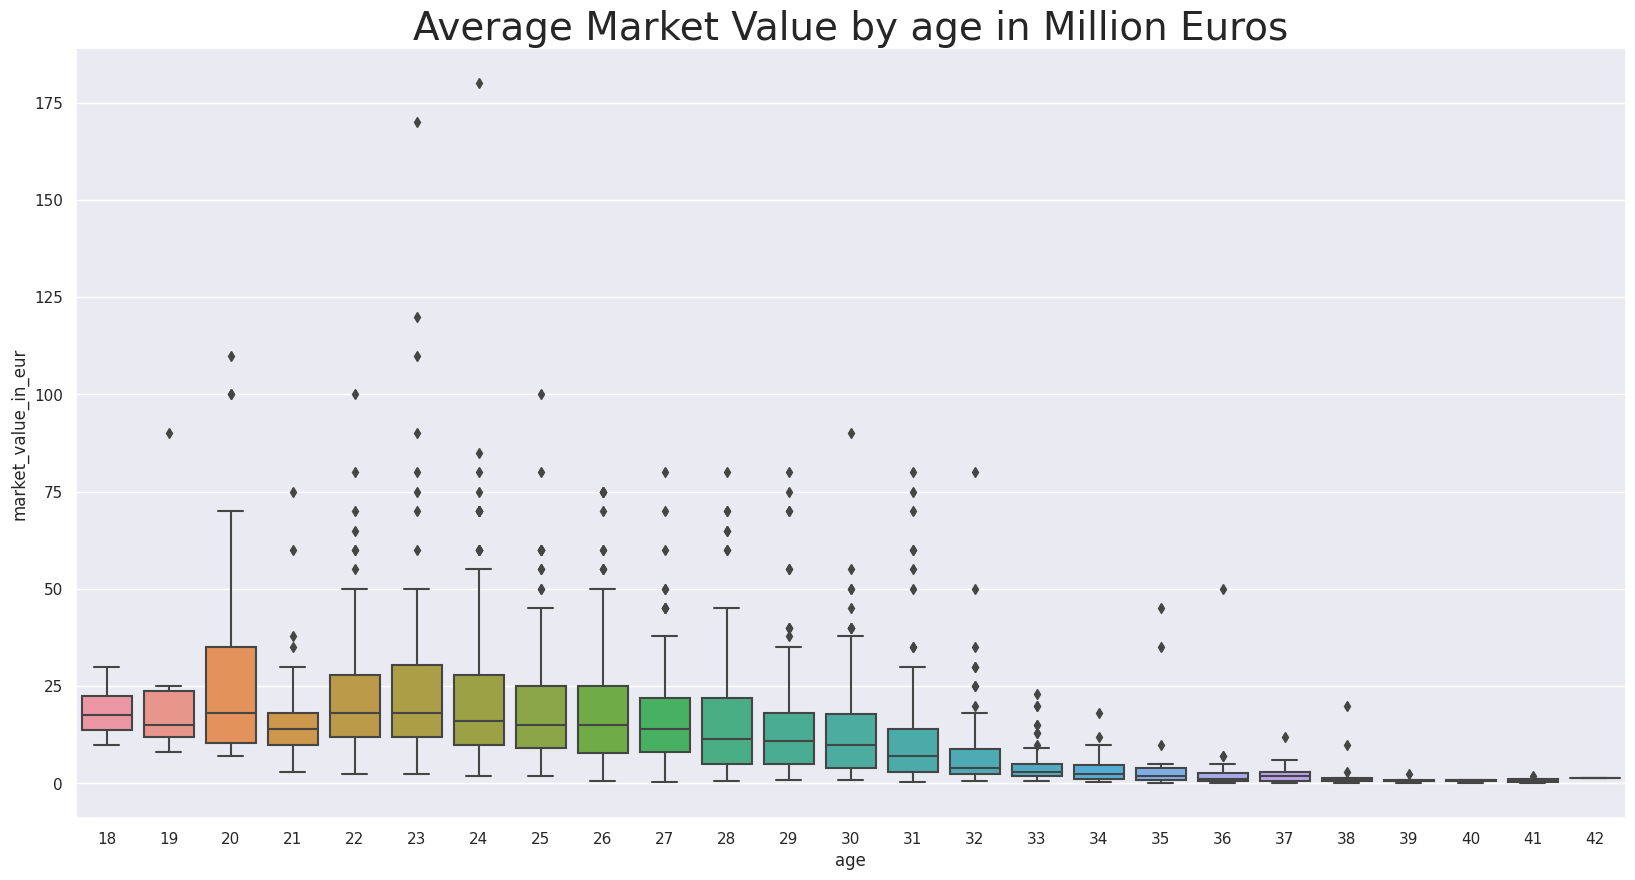

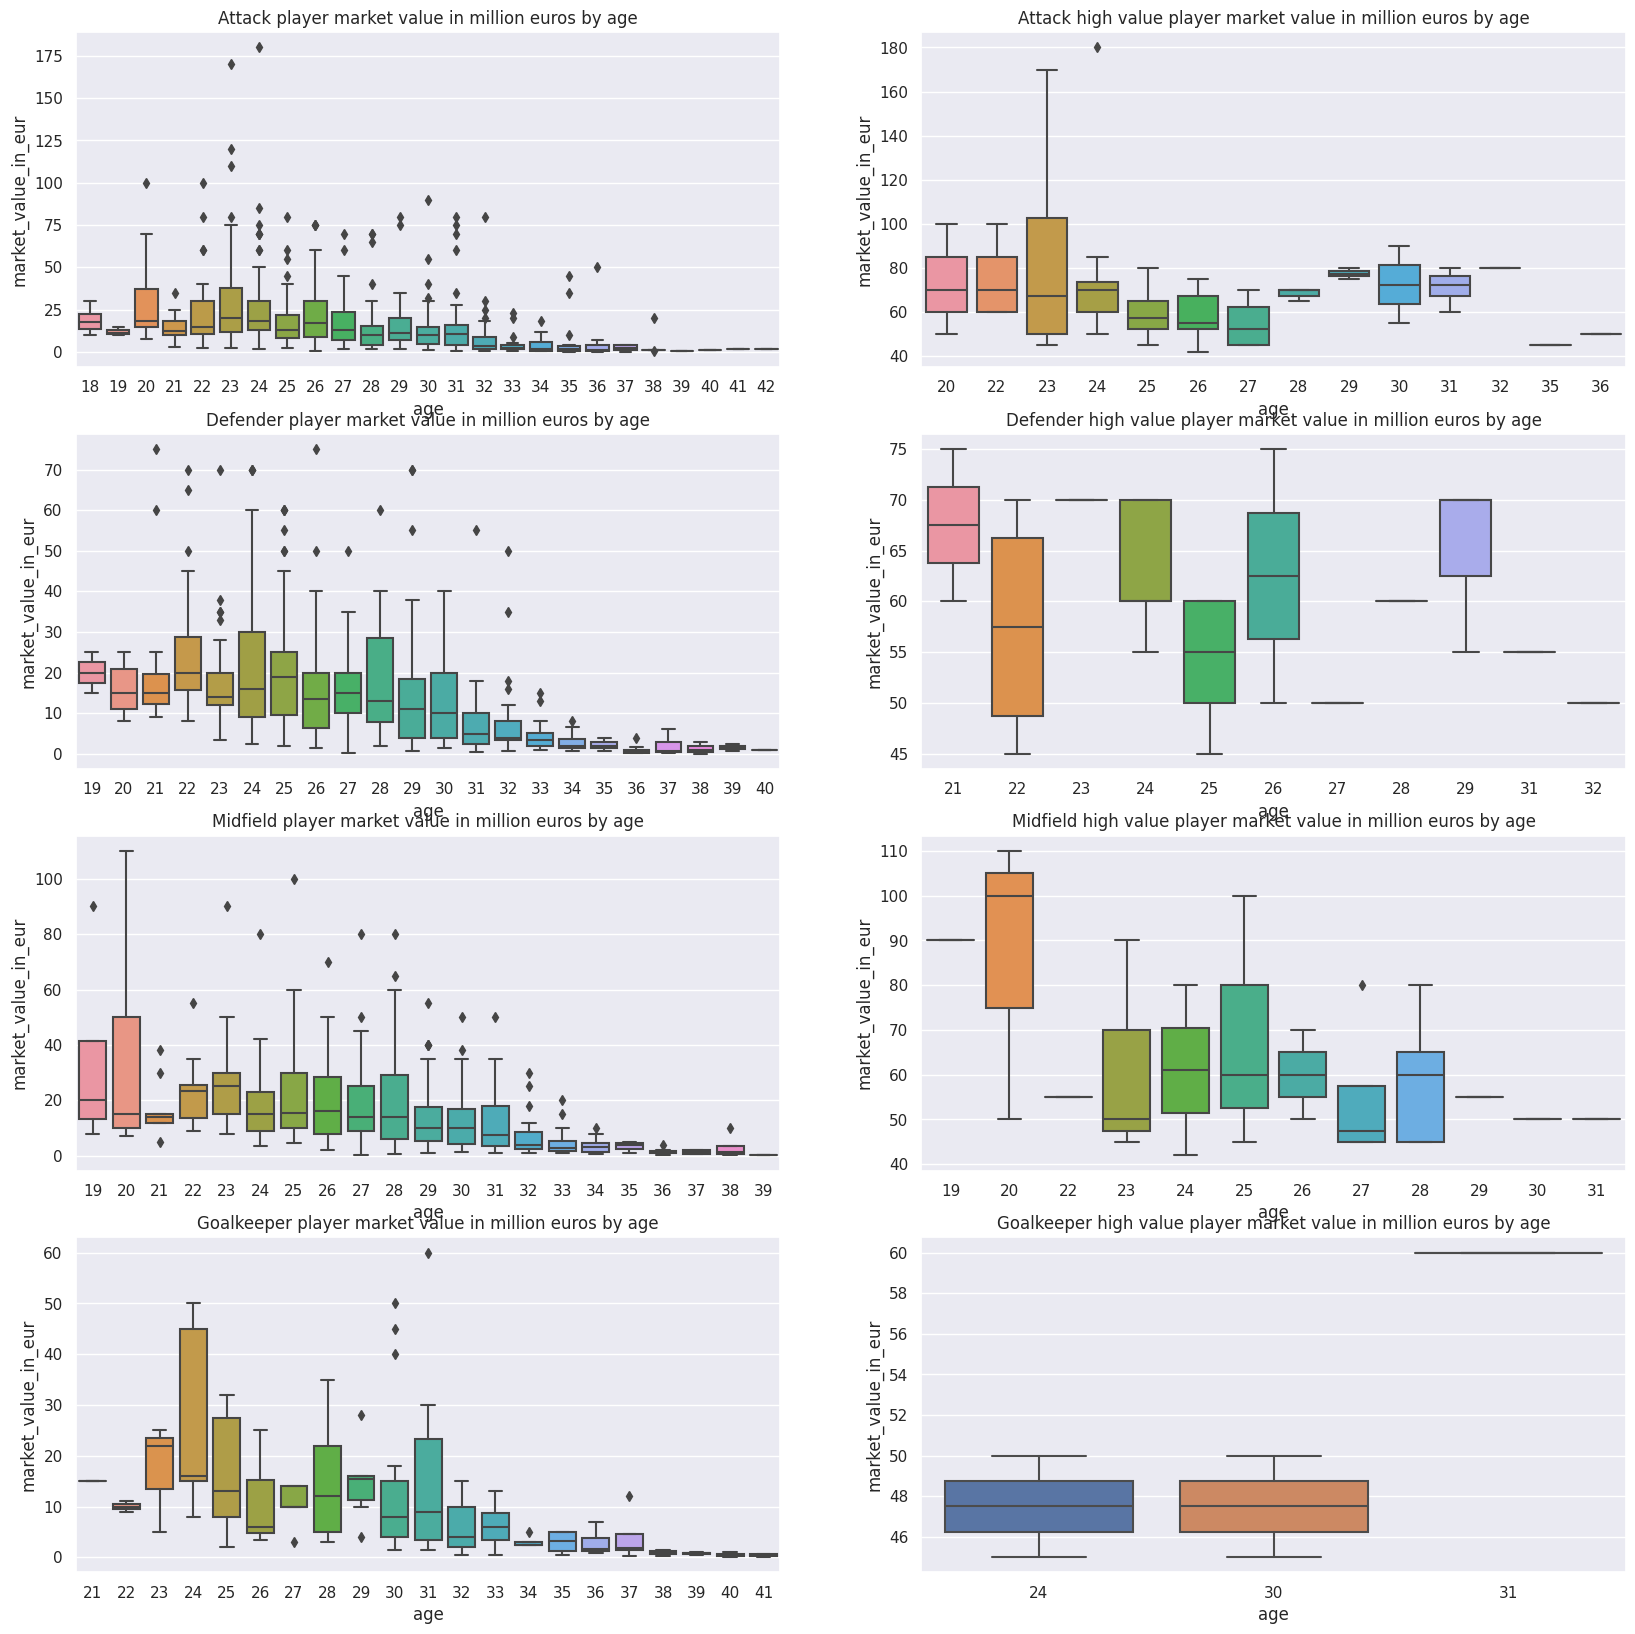

In [12]:
#market value by age
agegroups = players_df1.loc[:,['market_value_in_eur', 'age']] \
    .groupby(['age']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["age"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by age in Million Euros',fontsize=28)
plt.show() 
# show Market Value for each position by age
positions=players_df1.position.unique()
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)
n=1
for position in positions:
    plt.subplot(4,2,n); n=n+1 
    players_df2 = players_df1[players_df1['position'] == position]
    agegroups = players_df2.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df2["age"], y=(players_df2['market_value_in_eur'])/1000000)
    title=str(position+' player market value in million euros by age');plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    agegroups = high_value_players_df.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["age"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' high value player market value in million euros by age'); plt.title(title)
plt.show()

**Data visualisation of market value by height**

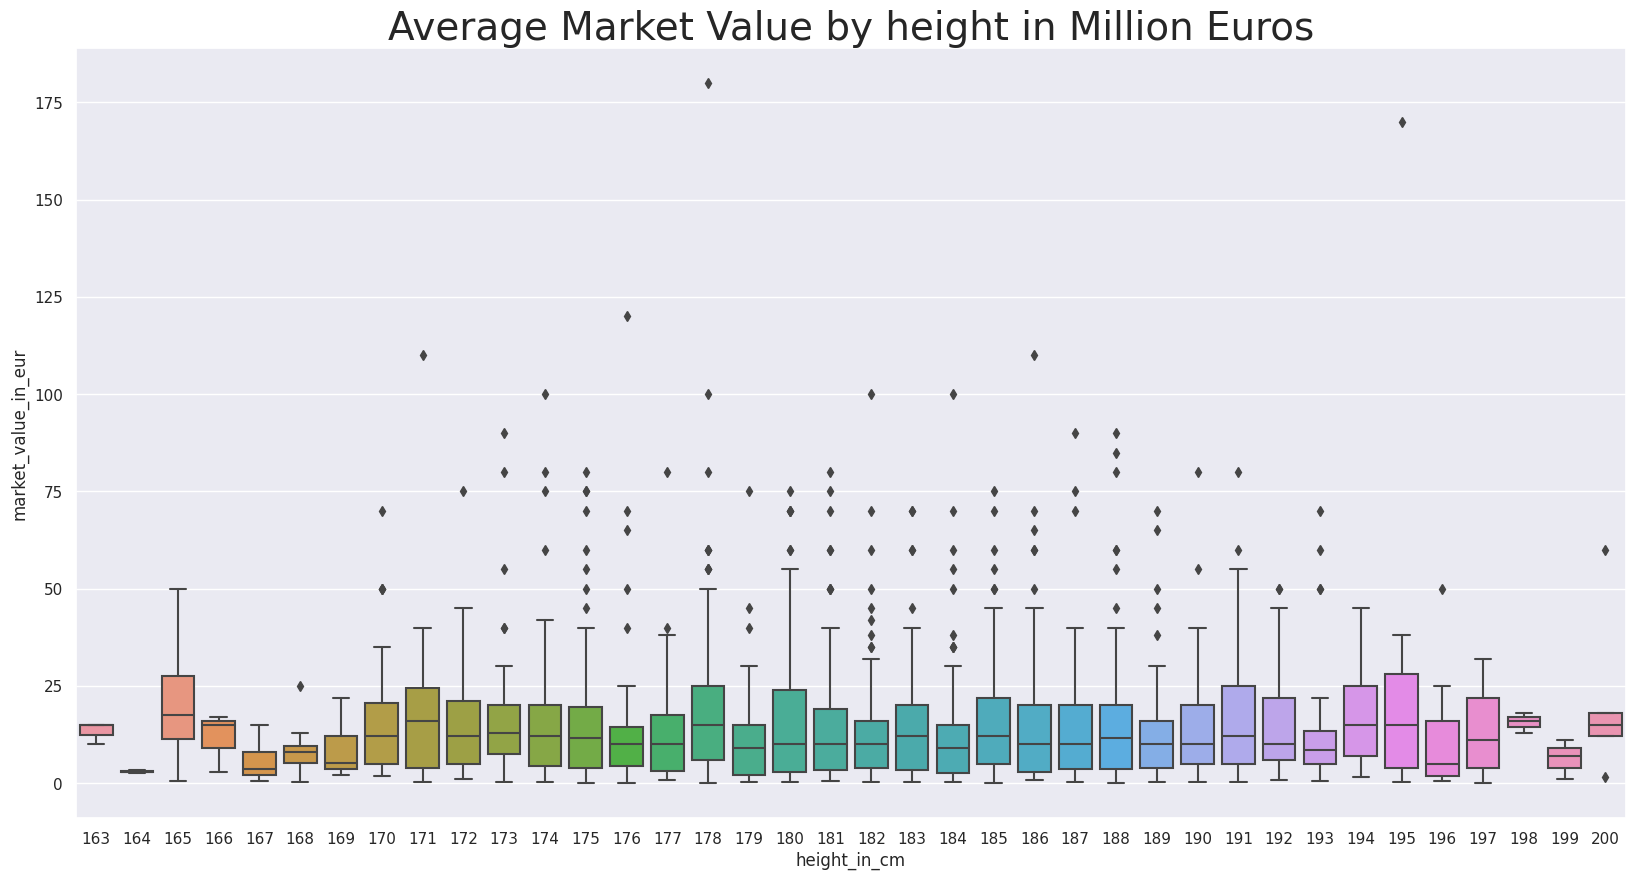

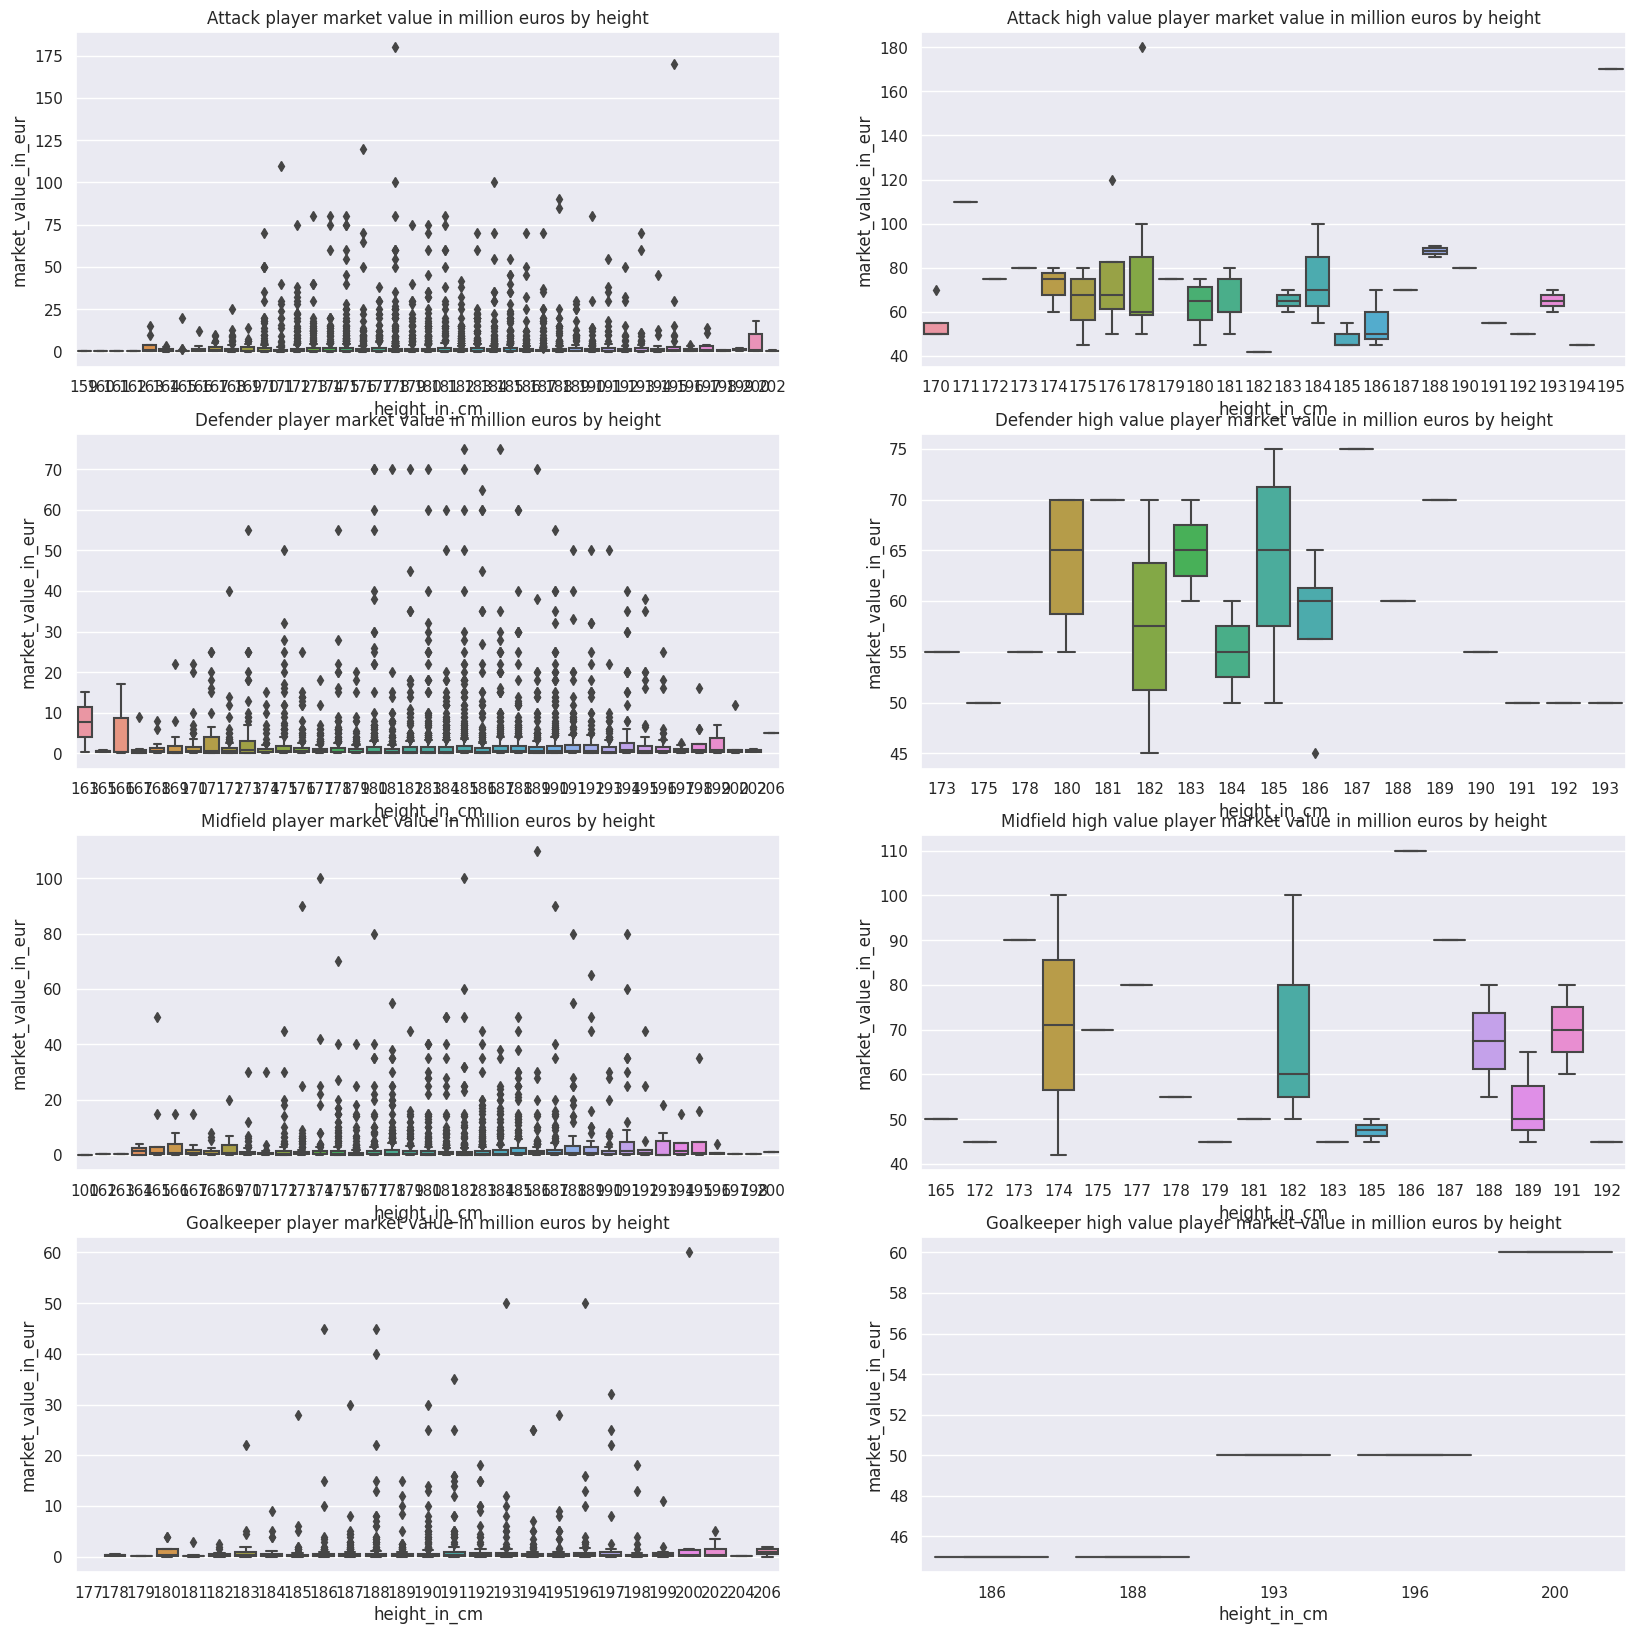

In [13]:
# drop players with no height
players_df3 = players_df[players_df['height_in_cm'] >= 1]

#market value by height
heightgroups = players_df1.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["height_in_cm"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by height in Million Euros', fontsize=28)
plt.show() 

# show Market Value for each position by height
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)

n=1
for position in positions:
    plt.subplot(4,2,n)
    n=n+1 
    players_df4 = players_df3[players_df3['position'] == position]
    heightgroups = players_df4.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df4["height_in_cm"], y=(players_df4['market_value_in_eur'])/1000000)
    title=str(position+' player market value in million euros by height')
    plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    heightgroups = high_value_players_df2.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["height_in_cm"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' high value player market value in million euros by height')
    plt.title(title)
plt.show()

**Top players by Market Value**

In [14]:
high_value_players_df2=high_value_players_df1.sort_values('market_value_in_eur',ascending = False)
highest_value_players_df2=high_value_players_df1.sort_values('highest_market_value_in_eur',ascending = False)

print((high_value_players_df2[['name',"market_value_in_eur"]]).head(15));print("*****")
print(highest_value_players_df2[['name',"highest_market_value_in_eur"]].head(15));print("*****")

                      name  market_value_in_eur
25338        Kylian Mbappé          180000000.0
25273       Erling Haaland          170000000.0
26532      Vinicius Junior          120000000.0
26907      Jude Bellingham          110000000.0
25276           Phil Foden          110000000.0
26579    Federico Valverde          100000000.0
26734                Pedri          100000000.0
24826          Bukayo Saka          100000000.0
22185        Jamal Musiala          100000000.0
26742                 Gavi           90000000.0
24837           Harry Kane           90000000.0
26573  Aurélien Tchouameni           90000000.0
23302          Rafael Leão           85000000.0
25304        Mohamed Salah           80000000.0
25298       Bernardo Silva           80000000.0
*****
                         name  highest_market_value_in_eur
25338           Kylian Mbappé                  200000000.0
25340            Lionel Messi                  180000000.0
25397                  Neymar                  18

**Statistical Overview**

In [15]:
# print info and describe for each dataframe

for i, df in enumerate(dataframes):
    print("***********")
    print(df.info())
    print(df.describe())

***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151986 entries, 0 to 1151985
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   appearance_id           1151986 non-null  object
 1   game_id                 1151986 non-null  int64 
 2   player_id               1151986 non-null  int64 
 3   player_club_id          1151986 non-null  int64 
 4   player_current_club_id  1151986 non-null  int64 
 5   date                    1140047 non-null  object
 6   player_name             1151757 non-null  object
 7   competition_id          1151986 non-null  object
 8   yellow_cards            1151986 non-null  int64 
 9   red_cards               1151986 non-null  int64 
 10  goals                   1151986 non-null  int64 
 11  assists                 1151986 non-null  int64 
 12  minutes_played          1151986 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 114.3+ MB
None
        

**Collating All Player Data**

In [16]:
# This was by attempt to collate all of the player data, but i found a far more elegant solution from LOIS CORDEIRO see below

#Start with players_df
merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)

#next look at clubs_df
merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2022','games_2022','assists_2022','minutes_played_2022','goals_against_2022','goals_for_2022','clean_sheet_2022'])
for player_id in merged_players_df.player_id.unique():
    #print(players_df.current_club_id[(players_df.player_id==player_id)])
    club_id= players_df.current_club_id[(players_df.player_id==player_id)]
    #print(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    #print(clubs_df.squad_size[(clubs_df.club_id==int(club_id))])
    try:
        merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    except:
        merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
    merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))
#sort column order
columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022','clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
merged_players_df=merged_players_df[columns]
#print(merged_players_df.head())

#merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
print('Player and club data merged');#print(games_and_appearances_df.shape);print(games_and_appearances_df.columns);print(games_and_appearances_df.head(1))

Player and club data merged


In [17]:
#collate stats game, appearance and goal date for each player.
#code based on code from luis gasparcordeiro's notebook at https://www.kaggle.com/code/luisgasparcordeiro/market-value-eda/notebook

#merge games and appearances   
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022 

#create a function to collate player stats
def player_stats(player_id, season, df):
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet','yellow_cards','red_cards'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df
#print(player_stats(67064, 2014, games_and_appearances_df)) #test function works.

#iterate through players
for index in merged_players_df.index:
    id = merged_players_df.loc[index][0]
    #print(id)
    name = merged_players_df.loc[index][1]
    stats = player_stats(id, season, games_and_appearances_df)
    try:
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
    except:
        #print(id)
        n=n+1     
print('appearance,goal and card data merged')
print(merged_players_df.info());#print(merged_players_df.describe())

appearance,goal and card data merged
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17245 entries, 6 to 28488
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             17245 non-null  int64         
 1   games_2022                            17245 non-null  float64       
 2   minutes_played_2022                   17245 non-null  float64       
 3   goals_2022                            17245 non-null  float64       
 4   assists_2022                          17245 non-null  float64       
 5   goals_against_2022                    17245 non-null  float64       
 6   goals_for_2022                        17245 non-null  float64       
 7   clean_sheet_2022                      17245 non-null  float64       
 8   name                                  17245 non-null  object        
 9   position                           

**Pairplots**

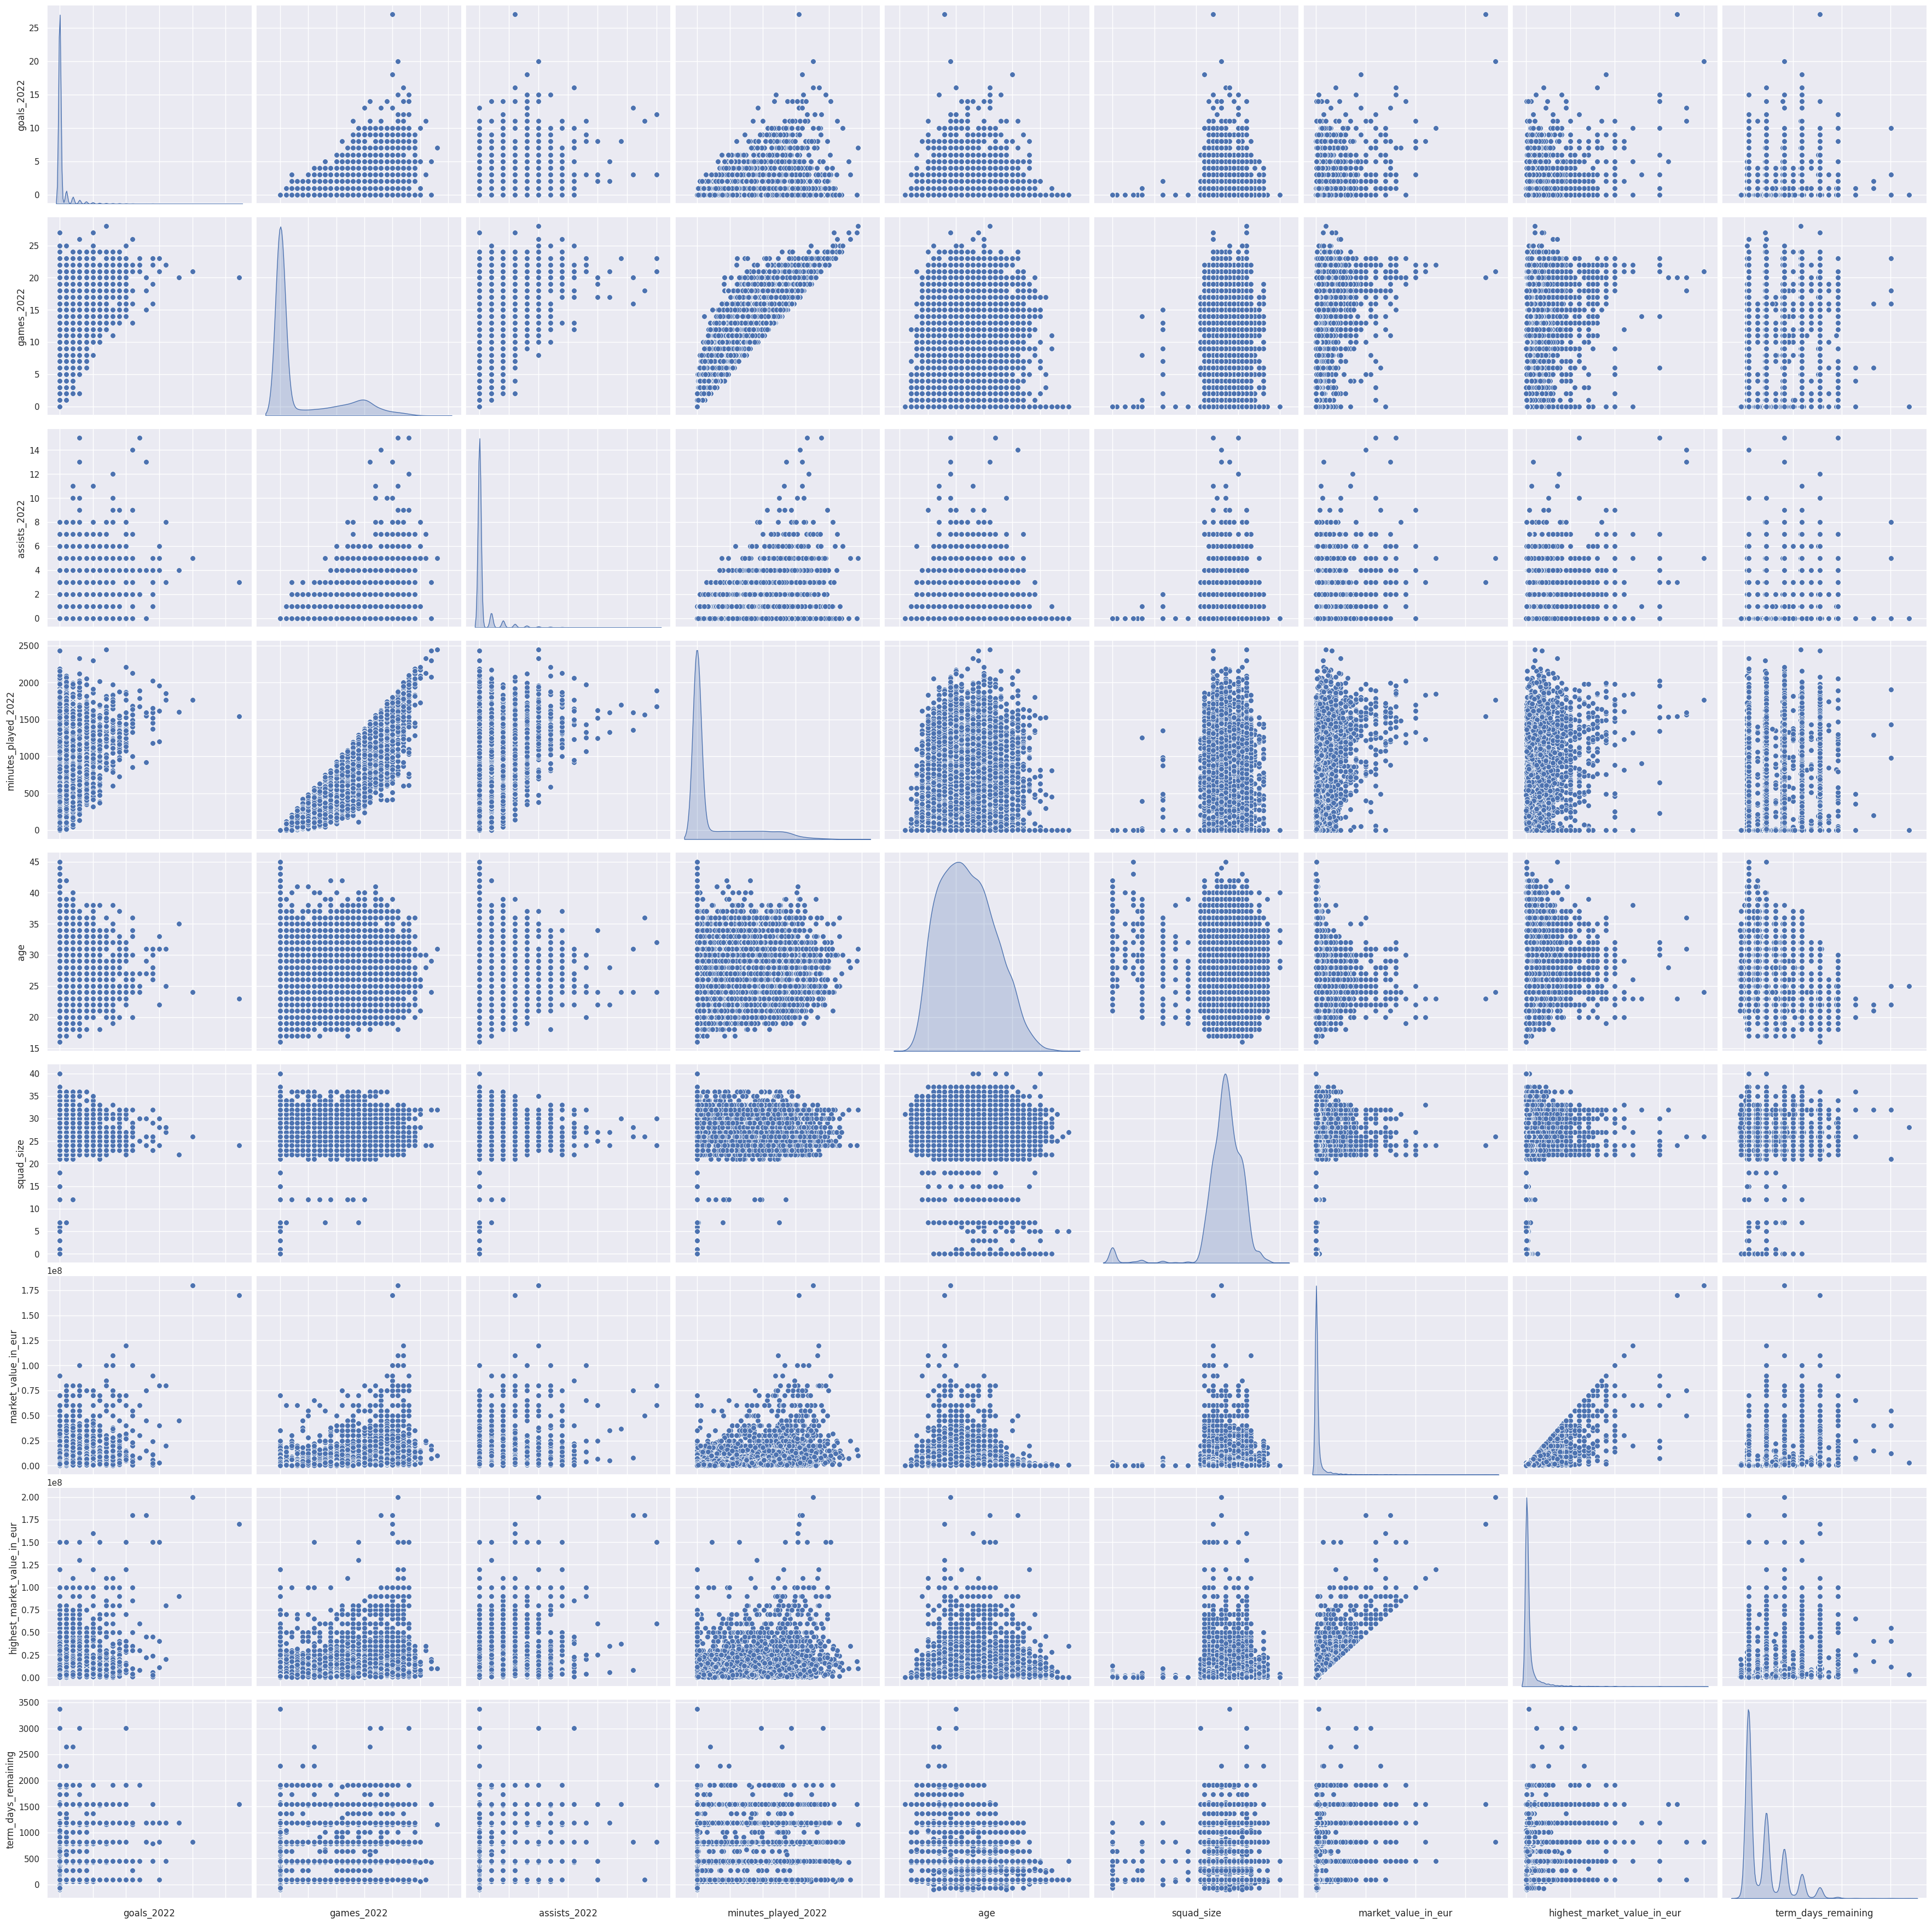

In [18]:
g = sns.pairplot(merged_players_df[[u'goals_2022', u'games_2022', u'assists_2022', u'minutes_played_2022',u'age',u'squad_size',u'market_value_in_eur',u'highest_market_value_in_eur',u'term_days_remaining']], palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

**Pearson Correlation of Features**

Index(['games_2022', 'minutes_played_2022', 'goals_2022', 'assists_2022', 'goals_against_2022', 'goals_for_2022', 'clean_sheet_2022', 'age', 'club_value', 'squad_size', 'term_days_remaining', 'market_value_in_eur', 'highest_market_value_in_eur', 'yellow_cards_2022', 'red_cards_2022'], dtype='object')


<Axes: title={'center': 'Pearson Correlation of Features'}>

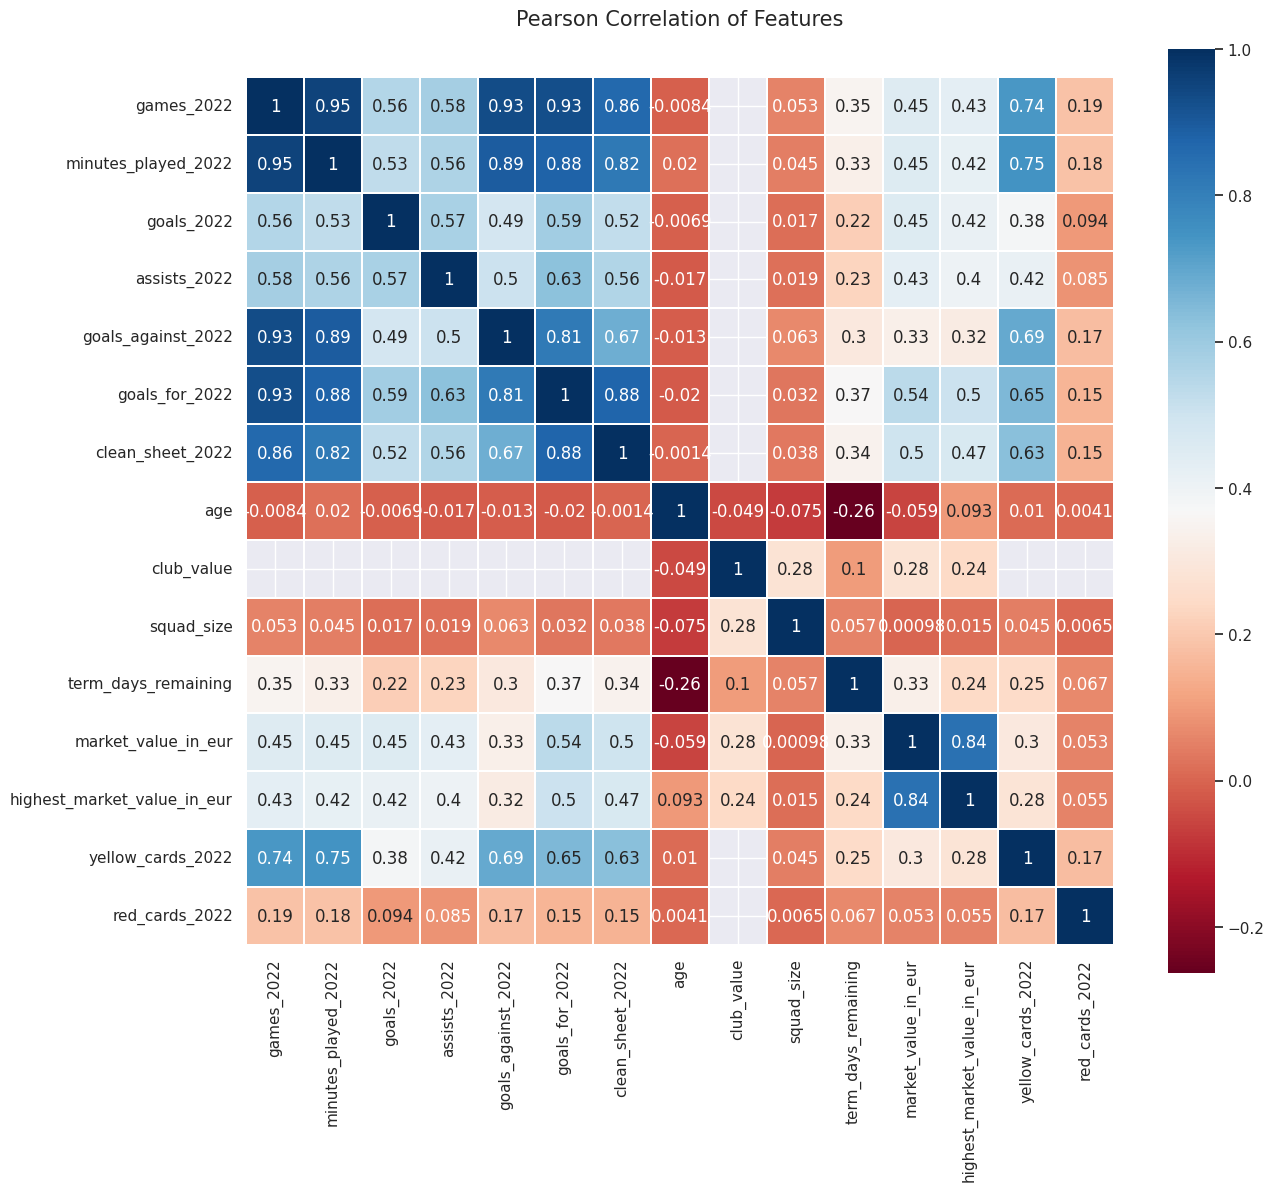

In [19]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
features_df=merged_players_df.drop(['player_id','name','position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

**Generate First Model**

In [20]:
#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size']
OTHER_COLUMNS=['position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#drop nan
merged_players_df=merged_players_df.dropna(subset=['market_value_in_eur'])
# create test and training data
X = merged_players_df[NUMERIC_COLUMNS].fillna(-1000)
y=merged_players_df['market_value_in_eur']
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#model data
clf = SVR(kernel="linear")
clf.fit(X_train, y_train)
#assess accurancy of model
print("Accuracy: {}".format(clf.score(X_test, y_test)))
#generate predictions
test = X_test[NUMERIC_COLUMNS].fillna(-1000)
Submission=clf.predict(test)
#print(Submission.head(5))

Accuracy: 0.08344975154382395


**Initial Feature Engineering**

In [21]:
#filter out only Gb players
merged_players_df1 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='GB1')]
# convert position categories to Columns for test data
dummies=pd.get_dummies(merged_players_df1[['position']], prefix_sep='_') #position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
print('initial feature engineering complete') #print(merged_players_df1.head())

initial feature engineering complete


**Re-evaluate model**

In [22]:
#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
# create test and training data
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#model data
clf = GradientBoostingRegressor(random_state=0)
#clf = SVR(kernel="linear",gamma="auto")
#clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)
#assess accurancy of model
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.6550145459850392


KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=10)

#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
# create test and training data
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [24]:
knn.score(X_test,y_test)


0.06442577030812324

In [25]:
y_pred = knn.predict(X_test)

y_pred

array([4.50e+07, 2.50e+05, 5.00e+05, 2.50e+05, 3.20e+07, 1.50e+05,
       1.80e+07, 3.00e+06, 1.70e+07, 3.00e+05, 2.00e+05, 1.50e+05,
       3.50e+07, 2.50e+05, 1.00e+06, 1.70e+07, 1.00e+05, 5.00e+05,
       1.80e+07, 9.00e+06, 2.20e+07, 1.80e+07, 1.50e+05, 1.80e+07,
       2.00e+06, 4.50e+07, 8.00e+06, 3.00e+05, 1.50e+05, 9.00e+06,
       2.00e+07, 1.00e+06, 3.50e+07, 2.00e+05, 5.00e+05, 8.50e+06,
       5.00e+06, 5.00e+06, 2.00e+05, 3.00e+07, 2.50e+07, 5.00e+04,
       2.50e+05, 3.20e+07, 1.50e+05, 2.00e+05, 2.00e+06, 2.50e+05,
       5.00e+05, 2.20e+07, 8.00e+06, 2.50e+07, 1.50e+05, 2.50e+07,
       1.80e+07, 5.00e+04, 1.50e+05, 1.50e+07, 5.00e+05, 6.00e+05,
       3.00e+05, 7.00e+07, 2.50e+07, 5.00e+05, 1.50e+06, 6.00e+05,
       8.00e+05, 5.00e+06, 2.80e+07, 3.00e+06, 1.80e+07, 2.00e+05,
       2.00e+07, 5.00e+04, 2.20e+06, 2.20e+07, 2.50e+05, 2.00e+05,
       5.00e+05, 5.00e+05, 4.50e+05, 1.50e+05, 1.20e+07, 5.00e+05,
       2.50e+05, 5.50e+06, 2.00e+05, 3.20e+07, 1.70e+07, 1.80e

In [26]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix

#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)

In [27]:
confusion_matrix(y_test,y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
#import classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     50000.0       0.00      0.00      0.00         4
     75000.0       0.00      0.00      0.00         3
    100000.0       0.00      0.00      0.00         6
    125000.0       0.00      0.00      0.00         2
    150000.0       0.07      0.25      0.11         8
    200000.0       0.12      0.22      0.15        18
    250000.0       0.08      0.27      0.12        15
    275000.0       0.00      0.00      0.00         0
    300000.0       0.08      0.07      0.07        14
    350000.0       0.00      0.00      0.00         6
    400000.0       0.00      0.00      0.00         9
    450000.0       0.00      0.00      0.00         2
    500000.0       0.06      0.22      0.10         9
    600000.0       0.00      0.00      0.00         7
    650000.0       0.00      0.00      0.00         1
    700000.0       0.00      0.00      0.00         7
    800000.0       0.00      0.00      0.00         8
    900000.0       0.00    

**SVM**

In [29]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
# create test and training data
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

cls = svm.SVC(kernel="rbf", probability=True)

cls.fit(X_train,y_train)

y_pred = cls.predict(X_test)

ac = accuracy_score(y_test,y_pred)
print(ac)

0.09243697478991597


**Further feature engineering**

In [30]:
# convert position categories to Columns for test data
dummies=pd.get_dummies(merged_players_df1[['sub_position']], prefix_sep='_') #sub position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
dummies=pd.get_dummies(merged_players_df1[['foot']], prefix_sep='_') #foot
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1) 
#print(merged_players_df1[NUMERIC_COLUMNS].head())

**Further model evaluation**

0:	learn: 10550223.2172234	total: 574us	remaining: 5.17ms
1:	learn: 10252883.6010770	total: 1.8ms	remaining: 7.2ms
2:	learn: 8823116.2581603	total: 2.46ms	remaining: 5.74ms
3:	learn: 8457527.6620955	total: 3.24ms	remaining: 4.86ms
4:	learn: 8197174.3657092	total: 4.07ms	remaining: 4.07ms
5:	learn: 8096015.8150838	total: 4.76ms	remaining: 3.18ms
6:	learn: 7525913.2737155	total: 5.46ms	remaining: 2.34ms
7:	learn: 7370131.2477119	total: 6.1ms	remaining: 1.52ms
8:	learn: 7154833.3811079	total: 6.71ms	remaining: 745us
9:	learn: 7077351.2213701	total: 7.24ms	remaining: 0us


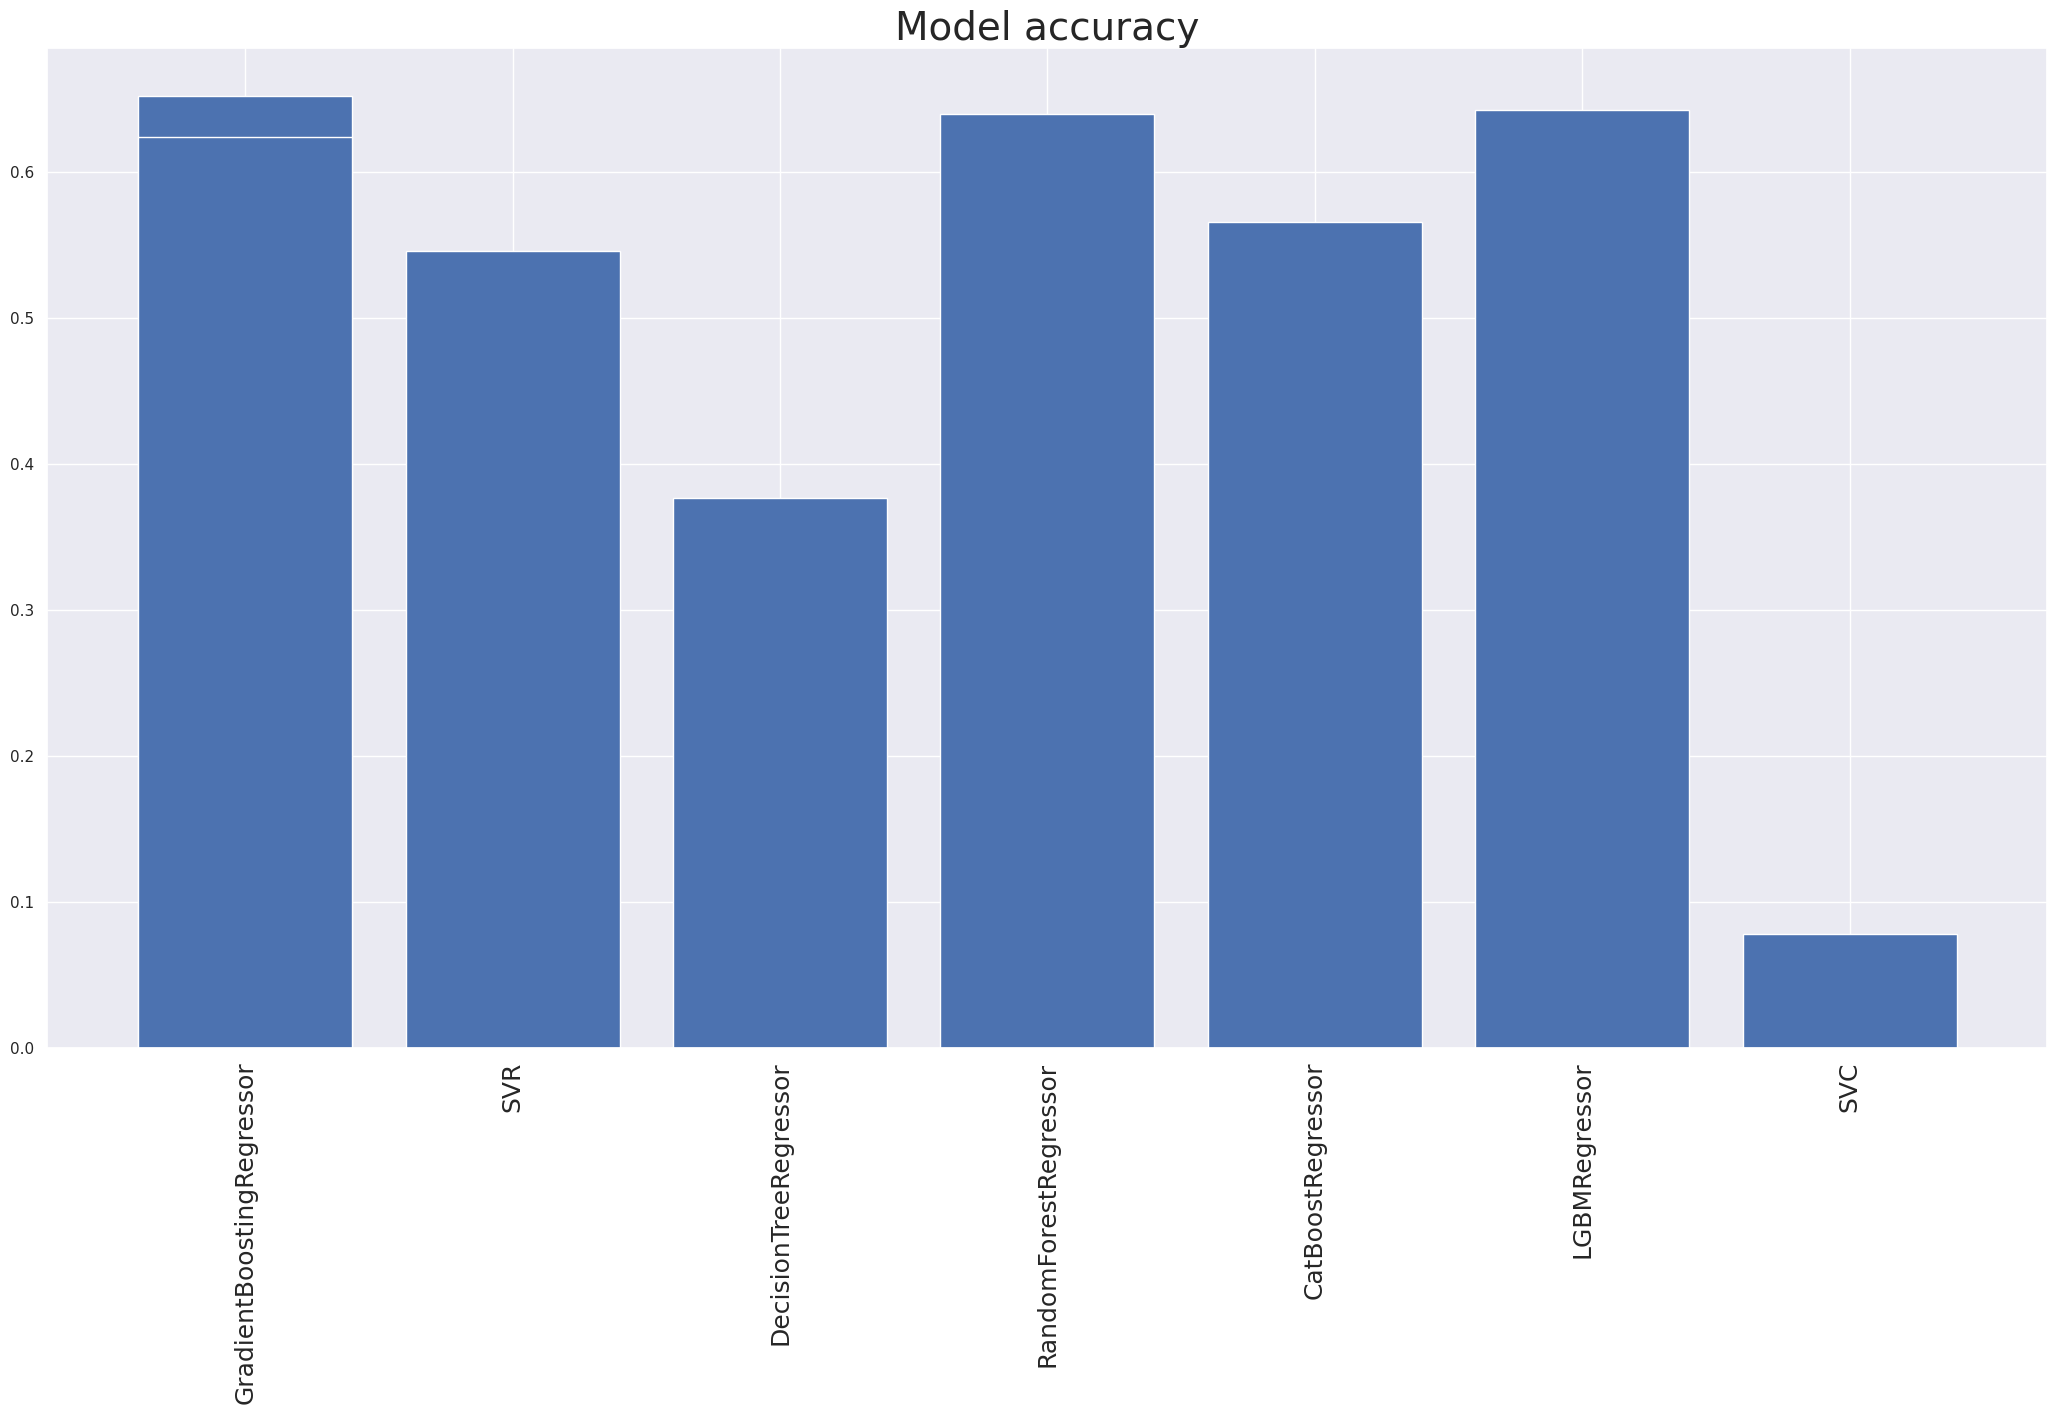

                       model  accuracy
0  GradientBoostingRegressor  0.652424
1                        SVR  0.546155
2      DecisionTreeRegressor  0.376479
3  GradientBoostingRegressor  0.623867
4      RandomForestRegressor  0.639608
5          CatBoostRegressor  0.566111
6              LGBMRegressor  0.642678
7                        SVC  0.078431


In [32]:
#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','height_in_cm','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield','sub_position_Attacking Midfield','sub_position_Central Midfield','sub_position_Centre-Back','sub_position_Centre-Forward','sub_position_Defensive Midfield','sub_position_Left Midfield','sub_position_Left Winger','sub_position_Left-Back','sub_position_Right Midfield','sub_position_Right Winger','sub_position_Right-Back','sub_position_Second Striker','foot_Left','foot_Right','foot_Both']
OTHER_COLUMNS=['last_season','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'] 
# create test and training data
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
y=merged_players_df1['market_value_in_eur']
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
comparisons_df = pd.DataFrame(columns=['model','accuracy'])
#model data
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
XGBR = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.04, random_state=1)
cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
lgbm=LGBMRegressor()
svm = svm.SVC(kernel="rbf", probability=True)

models=[gbr,svr,dtr,XGBR,rfr,cat,lgbm,svm]
for model in models:
    model.fit(X_train, y_train)
    #assess accurancy of model
    comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__,model.score(X_test, y_test)]
#create barchart to show performances
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = comparisons_df.model
y = comparisons_df.accuracy
ax.bar(x,y)
plt.xticks(fontsize=18, rotation=90)
plt.title('Model accuracy',fontsize=28)
plt.show()
print(comparisons_df)